## Projet 7: Implémentez un modèle de scoring

Etude data - Projet 7 - Maoulida ABDOULLATUF (Mars 2023)

Traitement des données sur Jupyter Notebook (Distribution Anaconda)

Etude réalisée en langage Python

*Data source* : [Jeu de données d’articles](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

## Présentation
Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
<img src = "logo_pret_a_depenser.png" width = "250" height = "100">

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

### Spécifications du dashboard
Michaël fourni un cahier des charges pour le dashboard interactif. Celui-ci devra a minima contenir les fonctionnalités suivantes :

- Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
- Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
- Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

# Partie 1: Exploration et néttoyage des données

### Importation des bibliothèques necessaires:

In [1]:

# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.


import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [3]:
#Graphing…
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':11,
     'ytick.labelsize':11,
     'axes.labelsize': 11,
     'legend.fontsize': 11,
     'axes.titlesize':11,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

### Chargement des données:

### Data description from [Kaggle](https://www.kaggle.com/c/home-credit-default-risk/data) : 


#### application_{train|test}.csv
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

#### bureau.csv
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

#### bureau_balance.csv
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

#### POS_CASH_balance.csv
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

#### credit_card_balance.csv
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

#### previous_application.csv
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

#### installments_payments.csv
- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.There is\
  a) one row for every payment that was made plus\
  b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home    Credit related to loans in our sample.

#### HomeCredit_columns_description.csv
This file contains descriptions for the columns in the various data files.

In [4]:
path_base_data = "C:/Users/aella/Desktop/P7_Model_de_scoring_Abdoullatuf_Maoulida_2022-2023/Data_P7/Base_data/Projet+Mise+en+prod+-+home-credit-default-risk/"

In [5]:
application_train = pd.read_csv(path_base_data + 'application_train.csv')
application_test = pd.read_csv(path_base_data + 'application_test.csv')
bureau = pd.read_csv(path_base_data + '/bureau.csv')
bureau_balance = pd.read_csv(path_base_data + 'bureau_balance.csv')
credit_card_balance = pd.read_csv(path_base_data + 'credit_card_balance.csv')

HomeCredit_columns_description = pd.read_csv(path_base_data + 'HomeCredit_columns_description.csv', sep = "\t", encoding='latin')

installments_payments = pd.read_csv(path_base_data + 'installments_payments.csv')
POS_CASH_balance = pd.read_csv(path_base_data + 'POS_CASH_balance.csv')
previous_application = pd.read_csv(path_base_data + 'previous_application.csv')

In [6]:
print("DOCUMENTATION :")
pd.set_option("max_colwidth", 400)
description = pd.read_csv(path_base_data + 'HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
description

DOCUMENTATION :


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


On va principalement explorer le fichier principal `application_train.csv` car en joignant avec les autres tous vont s'aligner en fonction de celui -ci et on fera eventuellement un nettoyage après regroupement des datasets.

### EDA application_train.csv | test.csv
La première partie permet d'illustrer globalement les données disponibles. Il est nécessaire d'approfondir l'analyse des features du ou des principaux fichiers.

In [7]:
print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


In [8]:
print("Dimension du fichier:", application_train.shape)
print("Aucune valeur dédoublée")
application_train.head()

Dimension du fichier: (307511, 122)
Aucune valeur dédoublée


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [9]:
#Check if 'TARGET' is the only difference ;-)
display(application_train.columns.difference(application_test.columns))
print("Check theses two files for Train (with TARGET) and Test (without TARGET).")

Index(['TARGET'], dtype='object')

Check theses two files for Train (with TARGET) and Test (without TARGET).


In [10]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


On a 65 + 41 = 106 variables de types numériques et 16 variables catégorielles

In [11]:
application_train.isna().mean()

SK_ID_CURR                      0.000000
TARGET                          0.000000
NAME_CONTRACT_TYPE              0.000000
CODE_GENDER                     0.000000
FLAG_OWN_CAR                    0.000000
FLAG_OWN_REALTY                 0.000000
CNT_CHILDREN                    0.000000
AMT_INCOME_TOTAL                0.000000
AMT_CREDIT                      0.000000
AMT_ANNUITY                     0.000039
AMT_GOODS_PRICE                 0.000904
NAME_TYPE_SUITE                 0.004201
NAME_INCOME_TYPE                0.000000
NAME_EDUCATION_TYPE             0.000000
NAME_FAMILY_STATUS              0.000000
NAME_HOUSING_TYPE               0.000000
REGION_POPULATION_RELATIVE      0.000000
DAYS_BIRTH                      0.000000
DAYS_EMPLOYED                   0.000000
DAYS_REGISTRATION               0.000000
DAYS_ID_PUBLISH                 0.000000
OWN_CAR_AGE                     0.659908
FLAG_MOBIL                      0.000000
FLAG_EMP_PHONE                  0.000000
FLAG_WORK_PHONE 

A part les cinq premieres variables, chaque variable contient au moins 13,5% de valeurs manquantes.

In [12]:
for i in application_train:
    if application_train[i].dtype == 'O': # Filter only the categorical variables 
        print(f"{i} contain:", application_train[i].unique())
        print("------------------")

NAME_CONTRACT_TYPE contain: ['Cash loans' 'Revolving loans']
------------------
CODE_GENDER contain: ['M' 'F' 'XNA']
------------------
FLAG_OWN_CAR contain: ['N' 'Y']
------------------
FLAG_OWN_REALTY contain: ['Y' 'N']
------------------
NAME_TYPE_SUITE contain: ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
------------------
NAME_INCOME_TYPE contain: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
------------------
NAME_EDUCATION_TYPE contain: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
------------------
NAME_FAMILY_STATUS contain: ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
------------------
NAME_HOUSING_TYPE contain: ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
------------------
OC

**On peut voir que certaines variables contiennent des 'XNA' comme par exemple "CODE_GENDER" ou encore "WEEKDAY_APPR_PROCESS_START"\
je vais donc les considérer comme des 'NA'.**

In [13]:
application_train.replace({'XNA': np.nan, 'XNP': np.nan, 'Unknown': np.nan}, inplace = True)
application_test.replace({'XNA': np.nan, 'XNP': np.nan, 'Unknown': np.nan}, inplace = True)

In [14]:
#Distribution of the Target Column
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

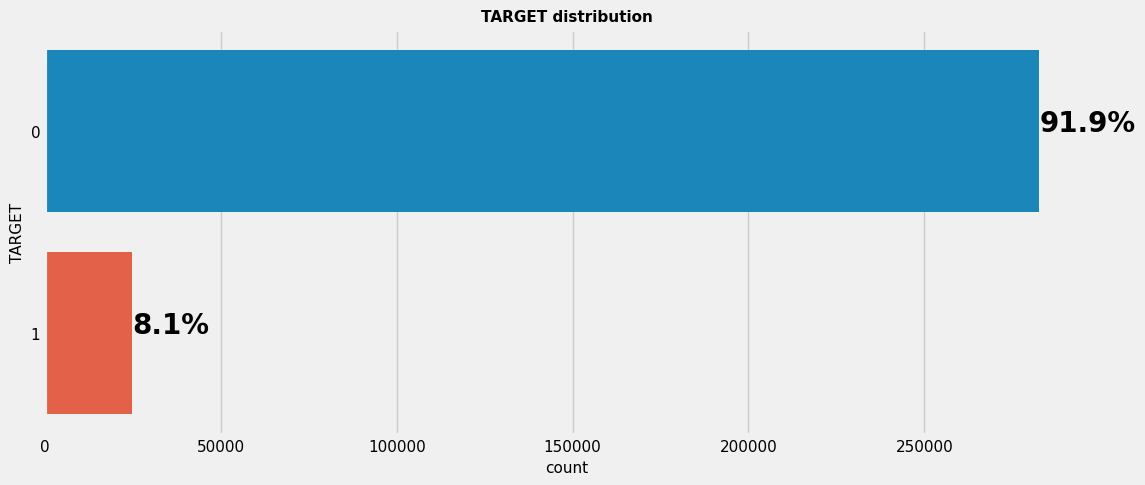

In [15]:
ax, fig = plt.subplots(figsize=(12,5)) 
ax = sns.countplot(y='TARGET', data=application_train)
ax.set_title("TARGET distribution")

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(application_train.TARGET))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
        
plt.show()

Notons des classes déséquilibrées. Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. Une fois que nous entrons dans des modèles d'apprentissage automatique plus sophistiqués, nous pouvons pondérer les classes par leur représentation dans les données pour refléter ce déséquilibre.

### Types de colonnes
Analyse rapide du type de features, mais surtout établir un aperçu afin de pouvoir poser une réflexion sur l'encodage des données catégorielles.

In [16]:
#Number of each type of column
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [17]:
#Number of unique classes in each object column
application_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement petit d'entrées uniques. Nous devrons trouver un moyen de traiter ces variables catégorielles…

### Valeurs manquantes
En modélisation, certains modèls tels que XGBoost peuvent gérer les valeurs manquantes sans imputation (un model que nous ne pourrons pas explorer par rapport à la performance relativement faible de notre machine). Plusieurs alternatives seront possibles: remplacer les NaN, supprimer les colonnes avec un pourcentage élevé de valeurs manquantes (impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle). Dans l'immédiat toutes les colonnes sont conservées…

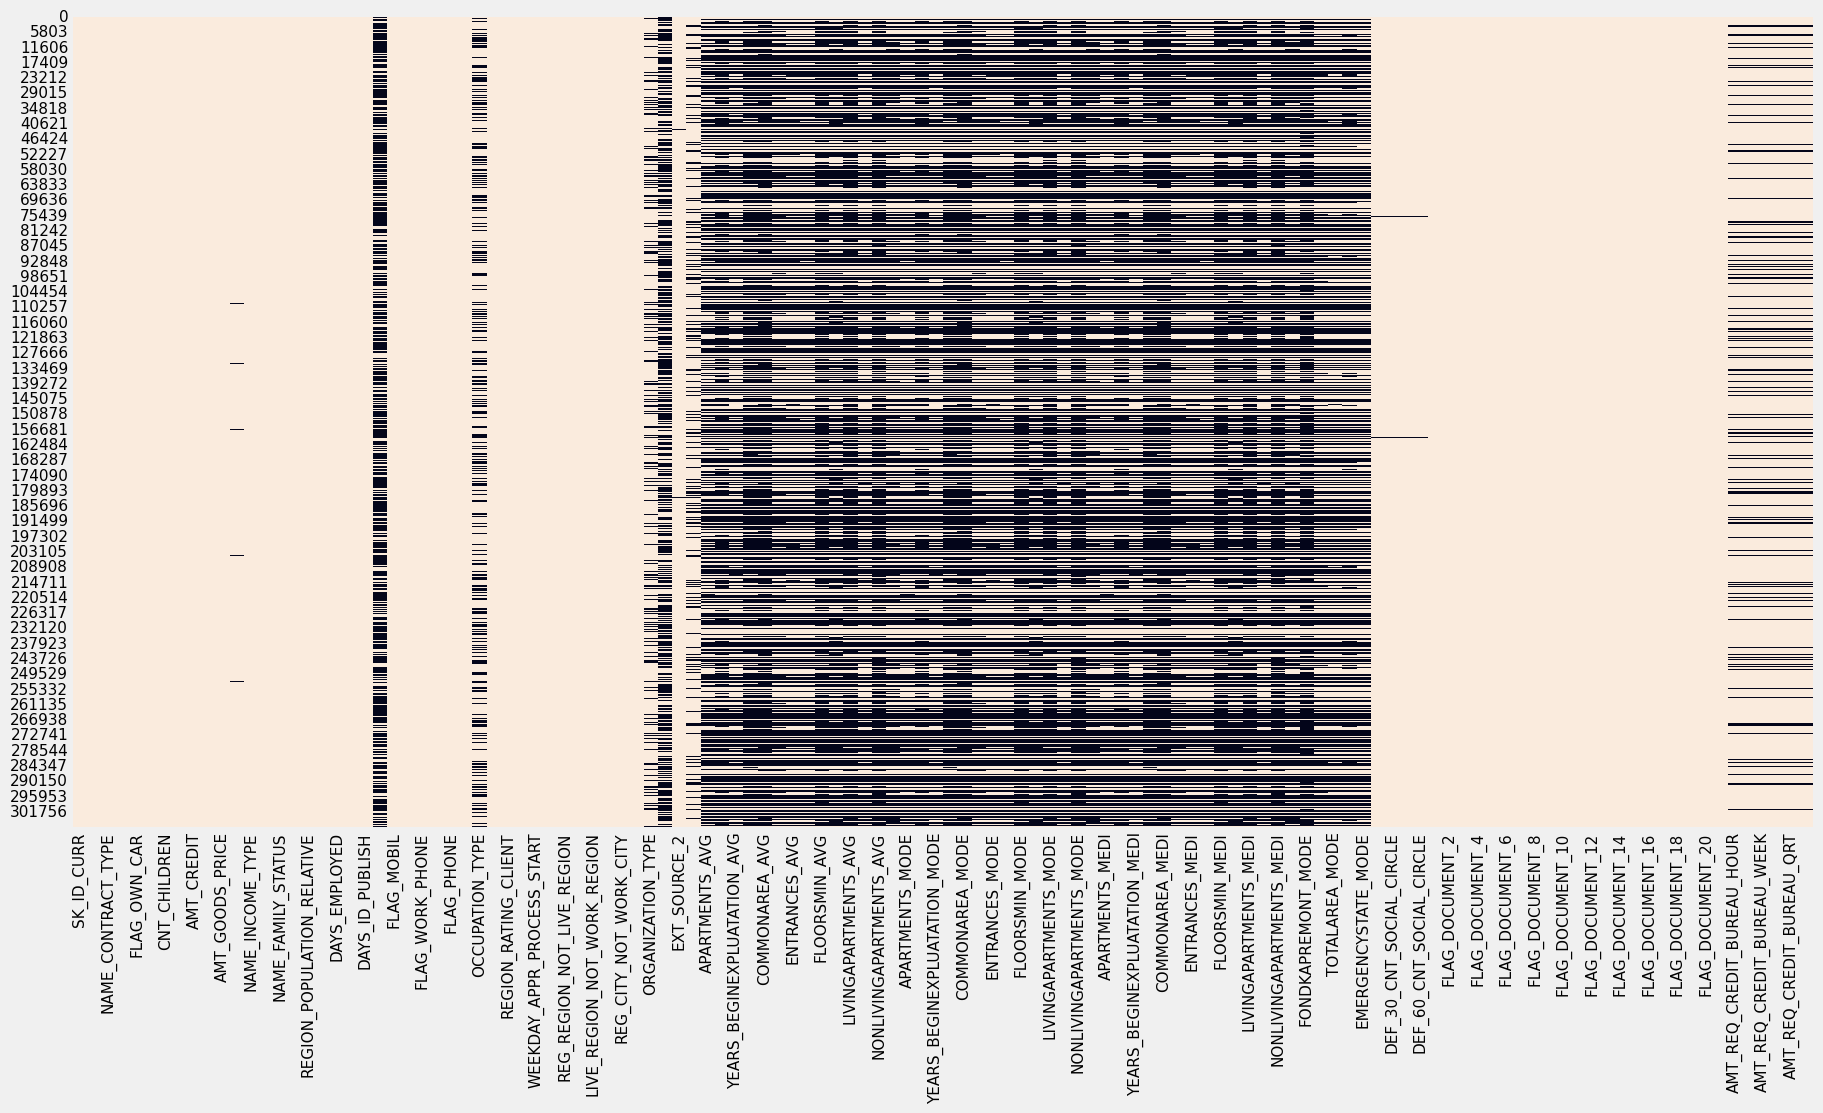

In [18]:
#Global view of the missing values (black)
plt.figure(figsize=(20,10))
sns.heatmap(application_train.notna(), cbar=False)
plt.show()

Une synthèse des données manquantes un peu confuse du fait du grand nombre de variables, mais il se dégage un premier constat qui montre que les NaN sont plus fortement présentent sur les caractéristiques des habitats (et non sur les crédits), comme l'atteste le TOP 10 ci-après…

In [19]:
def nan_check(data):
    '''Check Missing Values'''
    total = data.isnull().sum()
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2], 
                             axis=1, keys=['Total', '%']).sort_values('%', ascending=False)
    return missing_data

print('TOP 10 Missing values from Training dataset')
nan_check(application_train)[:10]

TOP 10 Missing values from Training dataset


,Total,%
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
COMMONAREA_MEDI,214865,69.87
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MODE,210199,68.35


In [20]:
print("Nb of columns in the training sample: " + str(len(nan_check(application_train))))

print("Nb of columns in the training sample with missing values: " + 
      str(len(nan_check(application_train)[nan_check(application_train)['Total']!=0])))

Nb of columns in the training sample: 122
Nb of columns in the training sample with missing values: 70


### Outliers, valeurs atypiques, anormales
En préambule, le constat est simple, des variables comme `DAYS_BIRTH` ou `DAYS_EMPLOYED` ont des valeurs négatives. Il est donc important de pouvoir analyser et si besoin rectifier ce type de données.

In [21]:
#Client's age in days at the time of application (def. from HomeCredit_columns_description.csv)
application_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

Les valeurs de la colonne `DAYS_BIRTH` sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Il est nécessaire de modifier cette variable pour obtenir des chiffres plus compréhensibles pour l'analyse.

In [22]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

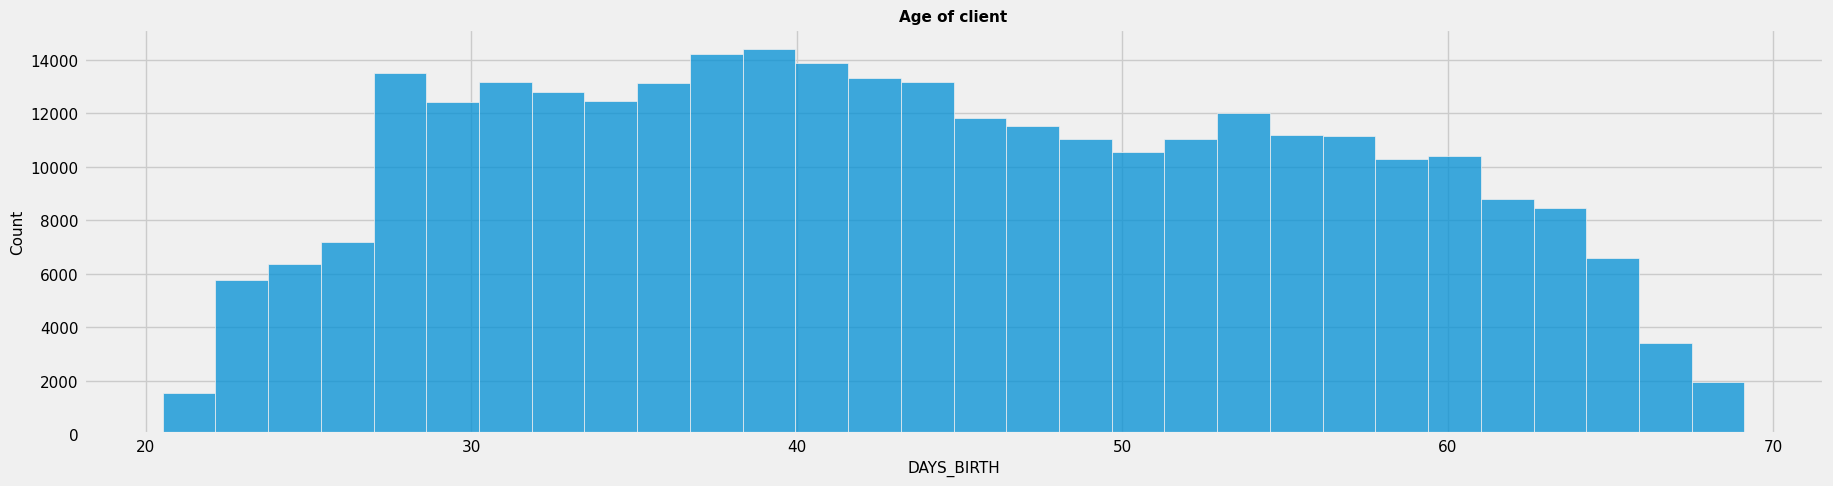

In [23]:
plt.figure(figsize=(20, 5))
sns.histplot((application_train['DAYS_BIRTH'] / -365), bins = 30).set_title('Age of client')
plt.show()

In [24]:
#How many days before the application the perso... (def. from HomeCredit_columns_description.csv)
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

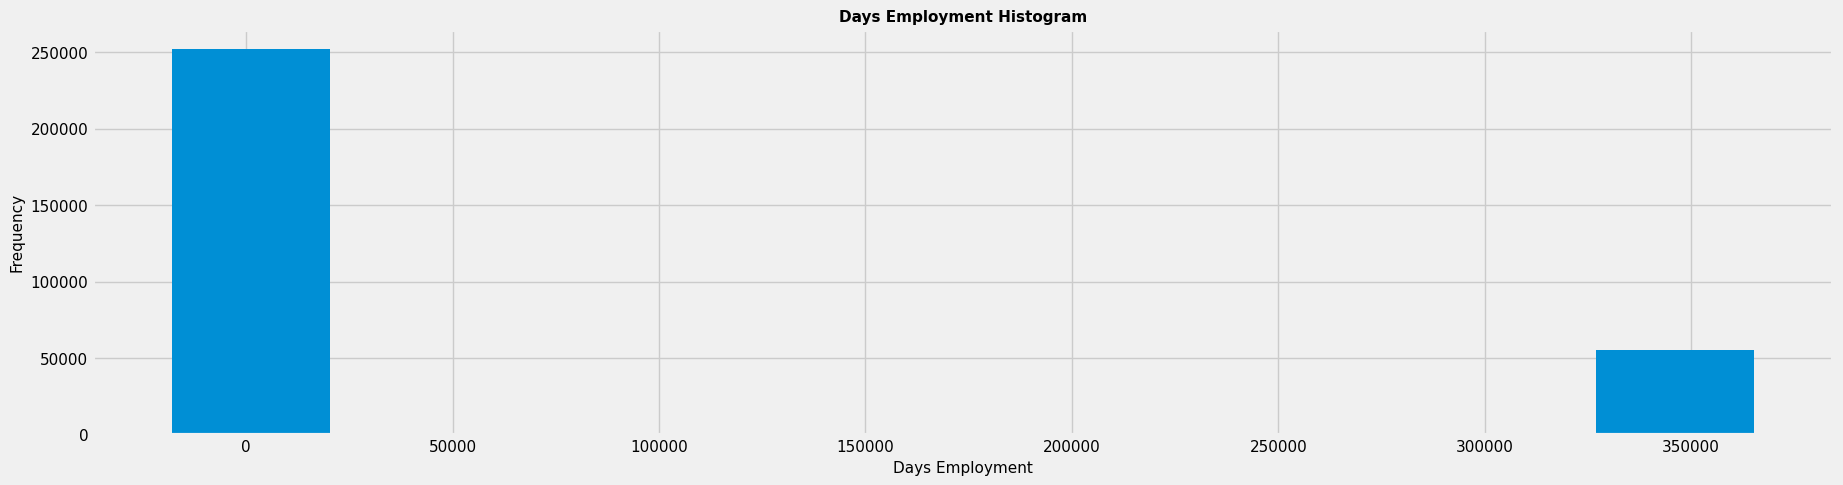

In [25]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram', figsize=(20,5));
plt.xlabel('Days Employment')
plt.show()

Idem ces données ne sont pas "normales" au sens où le Max. représente 1000 années (365243/365j). Est-ce un individu isolé? Plusieurs individus de l'échantillon?

In [26]:
print("%0.0f values with 365243 days employed for training data" % 
      len(application_train[application_train['DAYS_EMPLOYED'] == 365243]))
print("%0.0f Total values from days employed for training data" % application_train.shape[0])
print("-----------------------------------")
print("%0.0f values with 365243 days employed for testing data" % 
      len(application_test[application_test['DAYS_EMPLOYED'] == 365243]))
print("%0.0f Total values from days employed for testing data" % application_test.shape[0])

55374 values with 365243 days employed for training data
307511 Total values from days employed for training data
-----------------------------------
9274 values with 365243 days employed for testing data
48744 Total values from days employed for testing data


In [27]:
#Create an outliers flag column
application_train['DAYS_EMPLOYED_OUTLIERS'] = application_train["DAYS_EMPLOYED"] == 365243
application_test['DAYS_EMPLOYED_OUTLIERS'] = application_test["DAYS_EMPLOYED"] == 365243

#Replace outliers values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

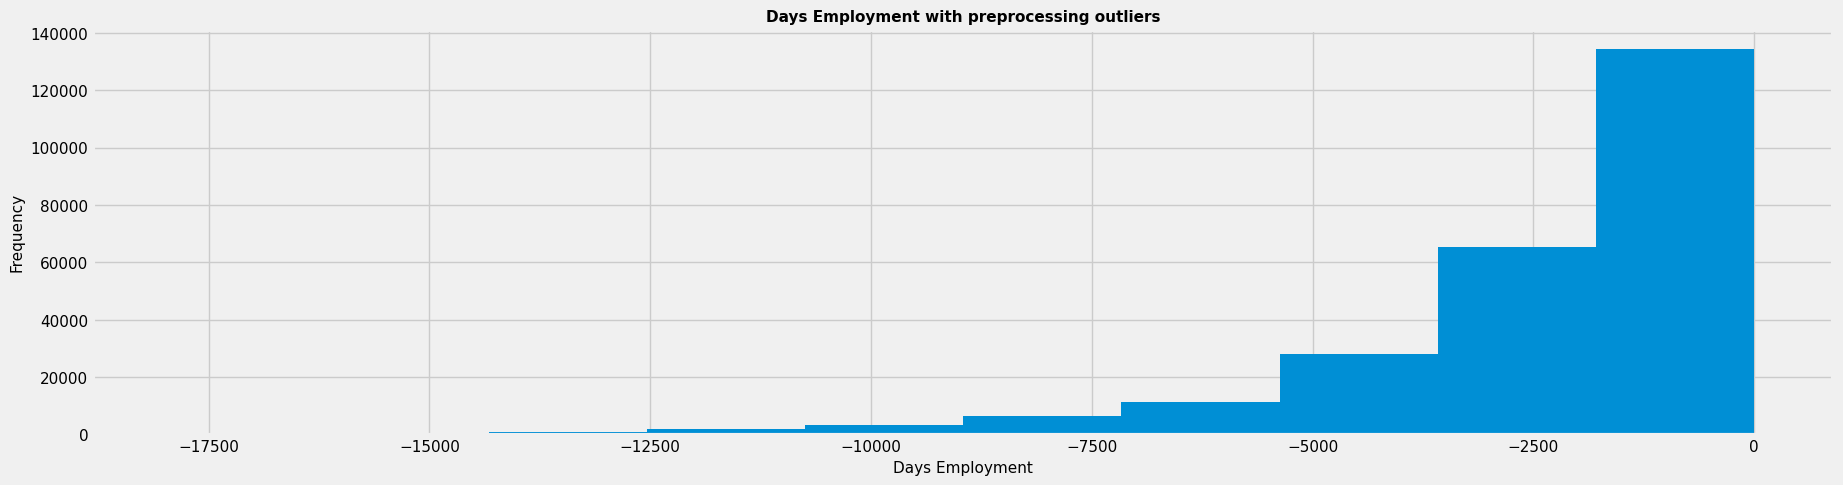

In [28]:
application_train['DAYS_EMPLOYED'].plot.hist(title ='Days Employment with preprocessing outliers', figsize=(20,5))
plt.xlabel('Days Employment')
plt.show()

### Fonctions pour faciliter l'analyse des principales variables…
Il est important de se focaliser sur les principales features pouvant être explicatives. Ici l'idée n'est pas de tout analyser en univarié ou multivarié, mais simplement d'avoir une image des points métiers qui aident à orienter nos décisions dans la "prise de risque" à l'attribution d'un crédit.

In [29]:
def plot_stat(data, feature, title) : 
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    plt.show()

In [30]:
def plot_percent_target1(data, feature, title) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Percent of target with value 1")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    plt.show()

**Loan types -** Distribution du type de prêts contractés + comparatif avec le pourcentage des prêts avec la valeur TARGET 1(prêt non retourné).

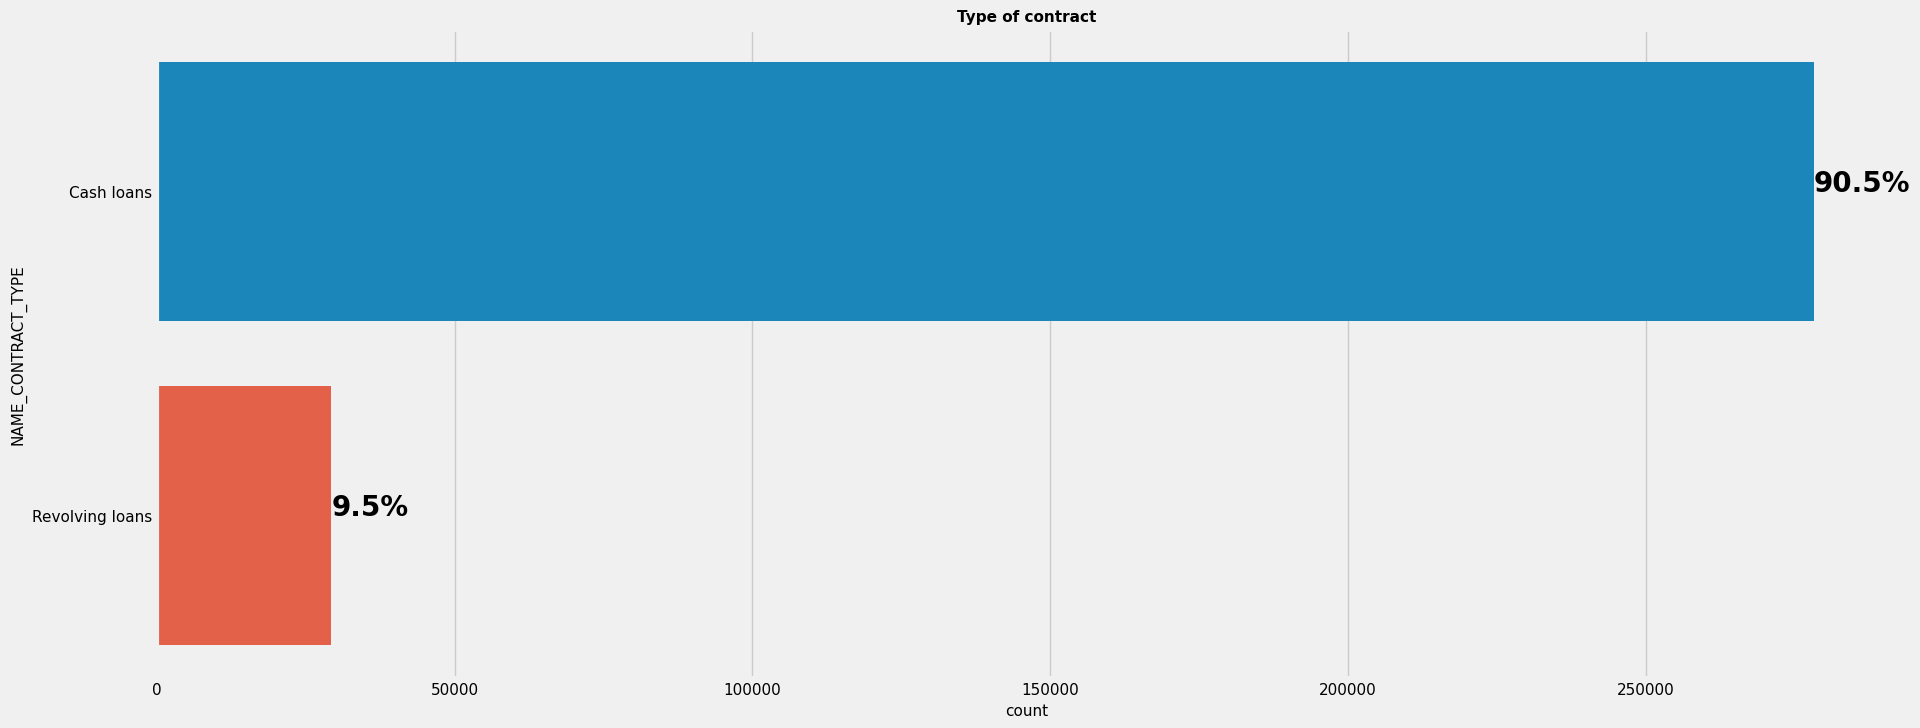

                                   -------------------------------------------------------


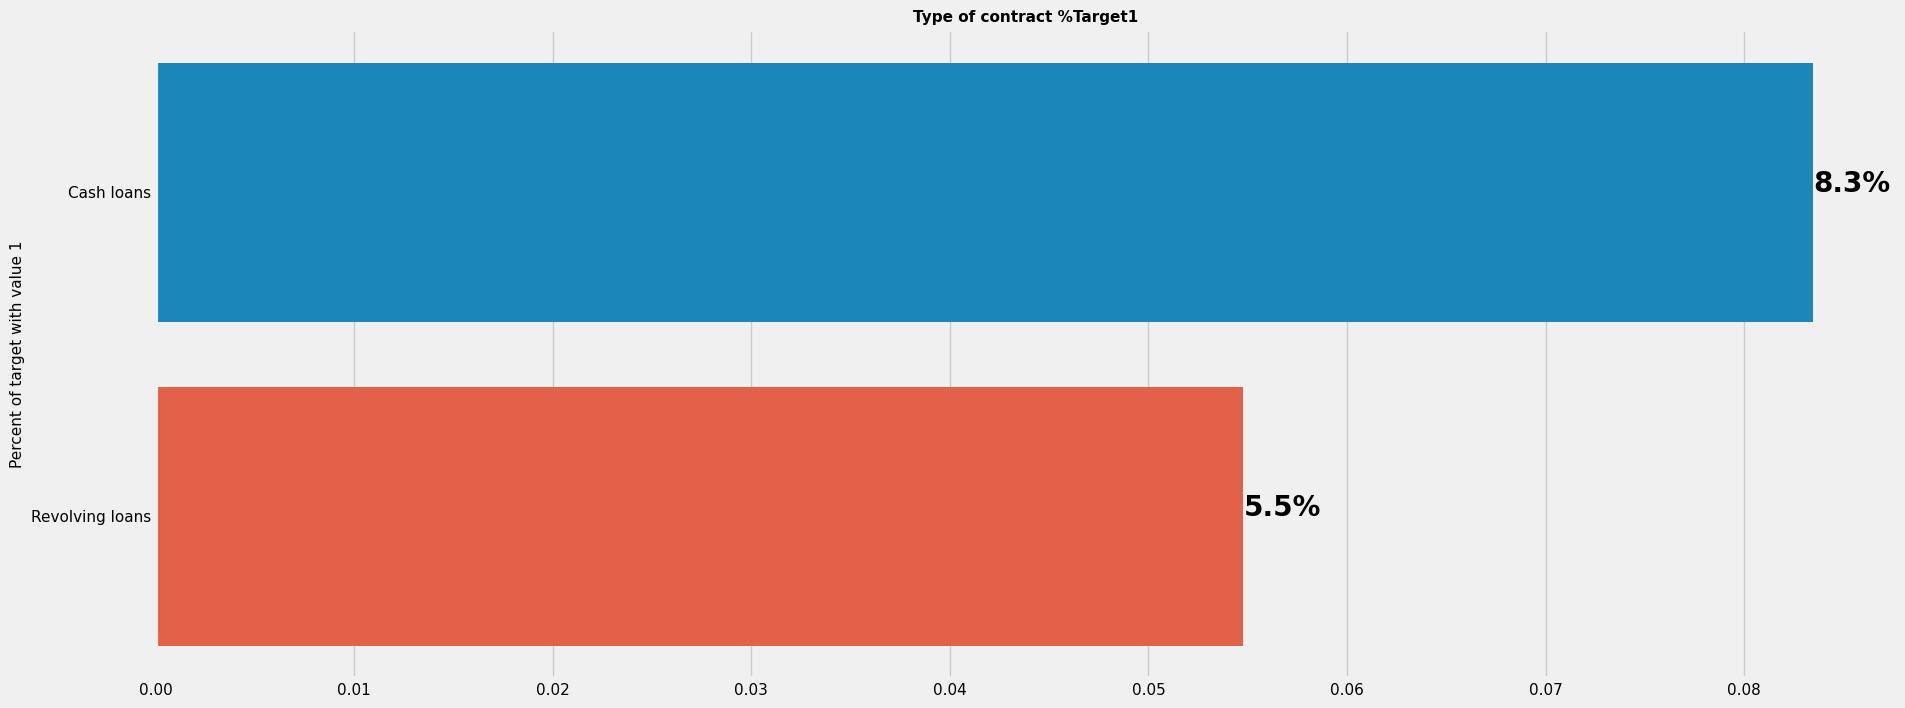

In [31]:
#NAME_CONTRACT_TYPE
plot_stat(application_train, 'NAME_CONTRACT_TYPE',"Type of contract")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_CONTRACT_TYPE',"Type of contract %Target1")

Les prêts renouvelables ne représentent qu'une petite fraction (10% environ) du nombre total de prêts; dans le même temps, un plus grand nombre de crédits renouvelables, par rapport à leur fréquence, ne sont pas remboursés.

**Client gender -** Distribution H/F clients, mais aussi le pourcentage des prêts (par sexe du client) avec la valeur TARGET 1 (prêt non retourné).

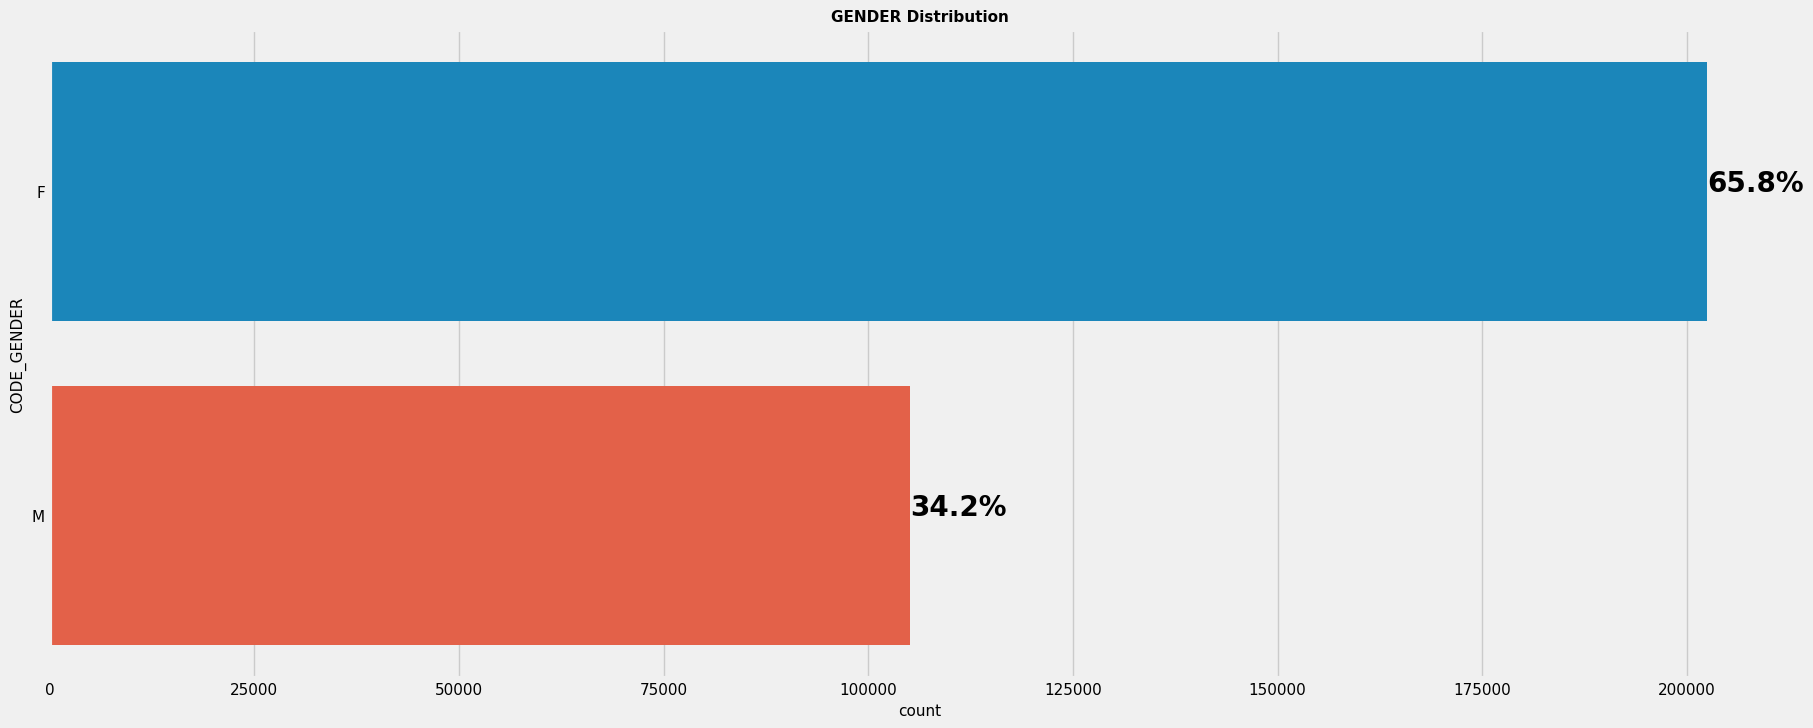

                                   -------------------------------------------------------


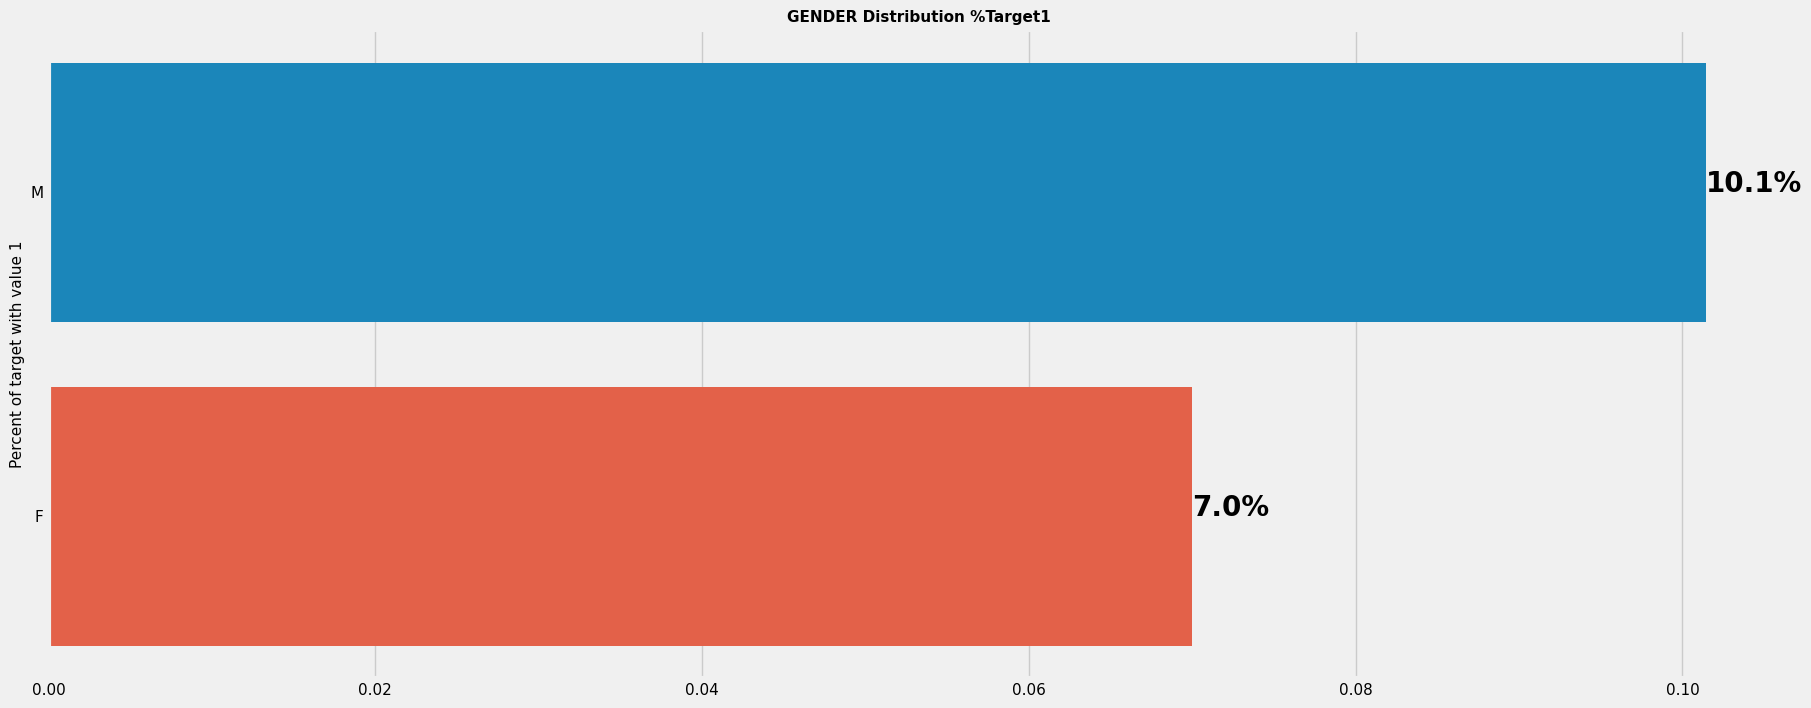

In [32]:
#CODE_GENDER
plot_stat(application_train, 'CODE_GENDER',"GENDER Distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'CODE_GENDER',"GENDER Distribution %Target1")

Le nombre de clients féminins est presque le double du nombre de clients masculins. En ce qui concerne le pourcentage de crédits en souffrance, les hommes ont plus de chances de ne pas rembourser leurs prêts (10%), comparativement aux femmes (7%).

**Flag own car -** Distribution d'un impact possible entre les clients propriétaire d'un véhicule et ceux qui ne le sont pas…

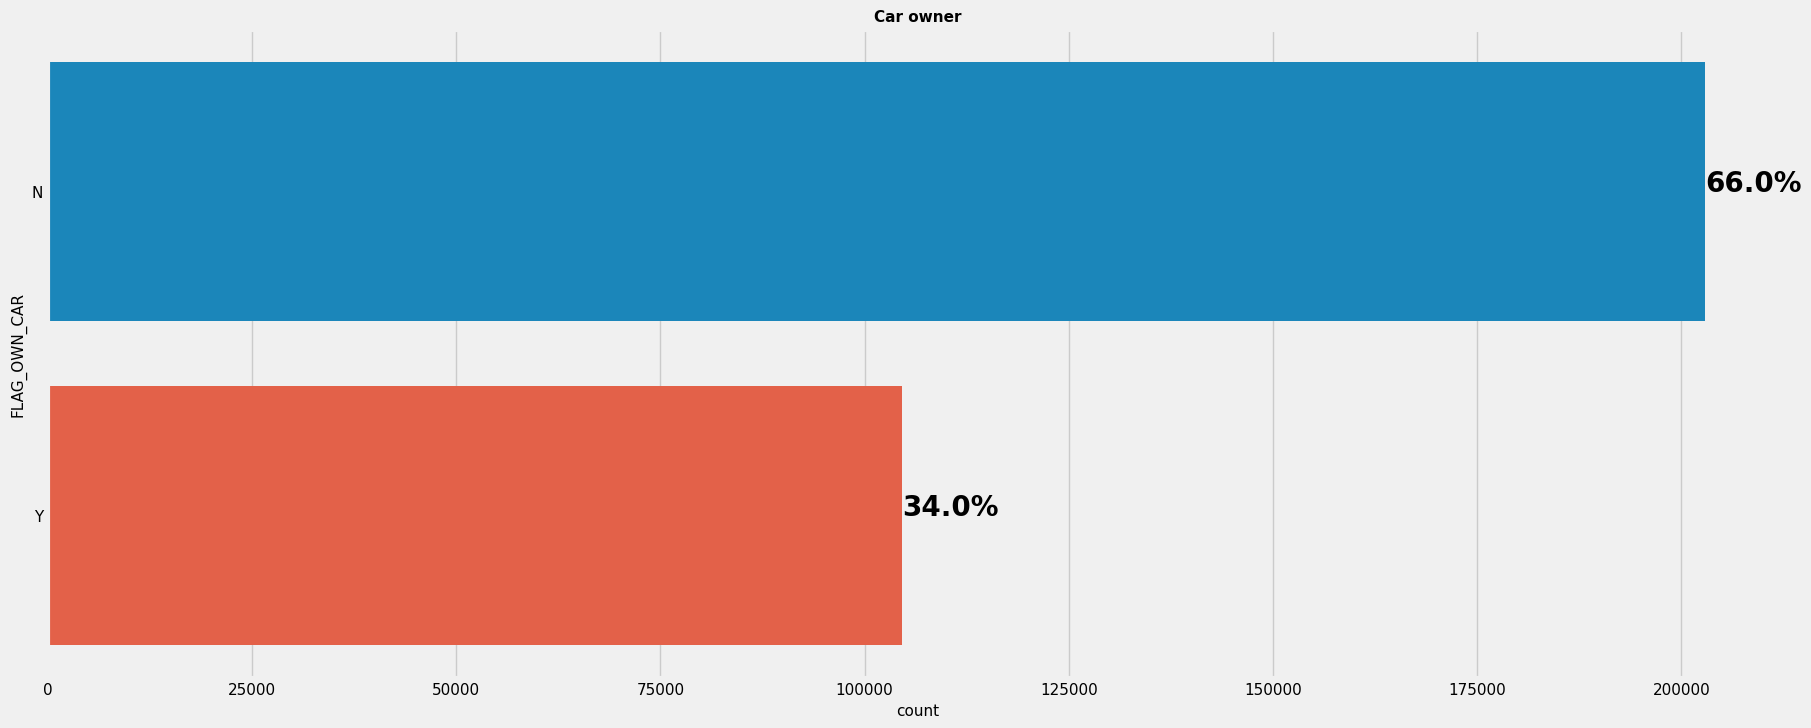

                                   -------------------------------------------------------


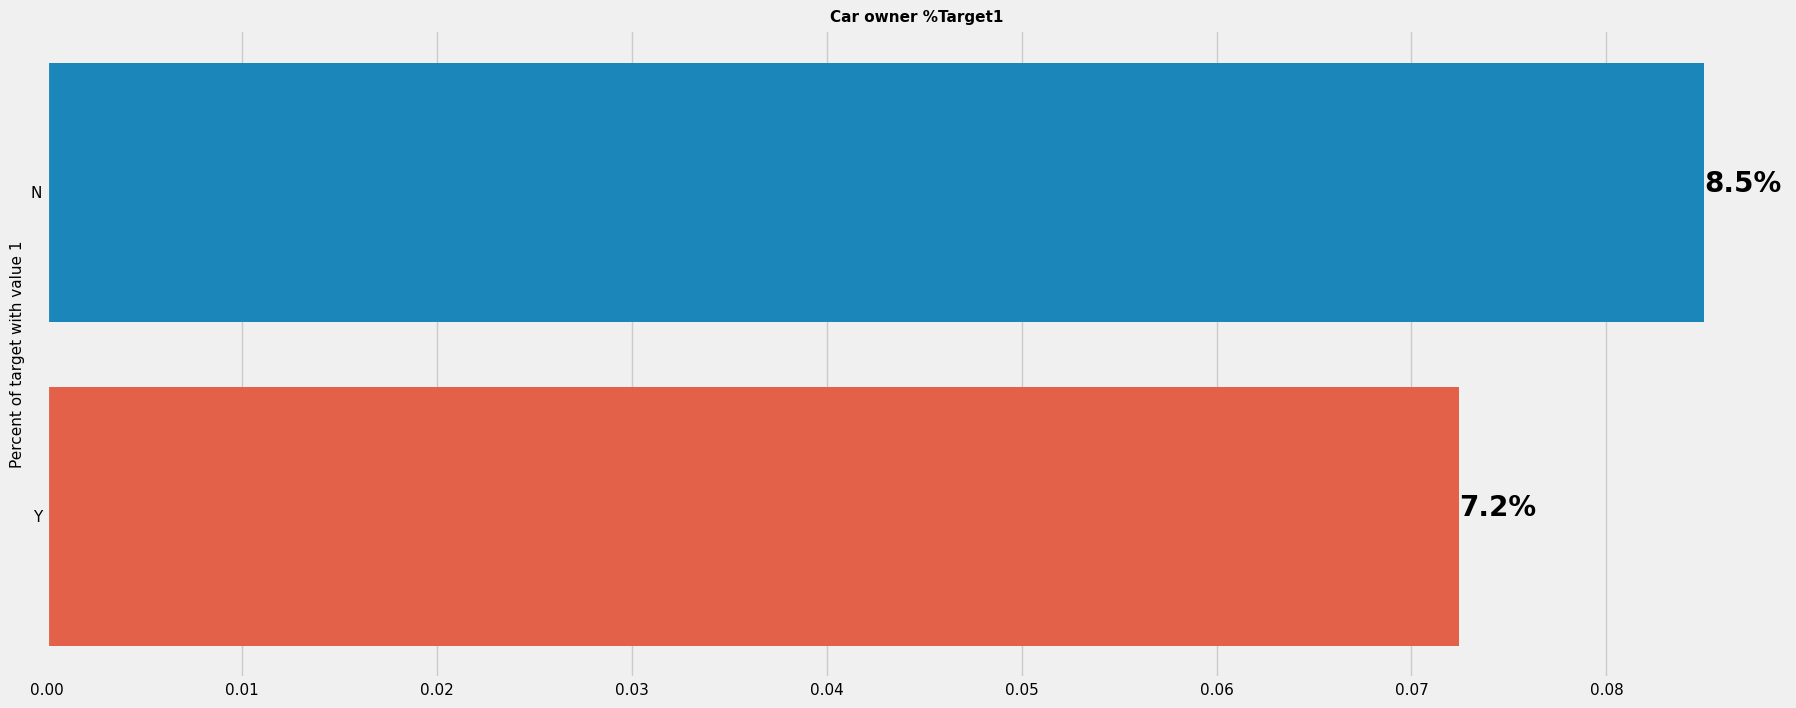

In [33]:
#FLAG_OWN_CAR
plot_stat(application_train, 'FLAG_OWN_CAR',"Car owner")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'FLAG_OWN_CAR',"Car owner %Target1")

Les deux catégories (propriétaire ou non) ont des taux de non-remboursement d'environ 8%.

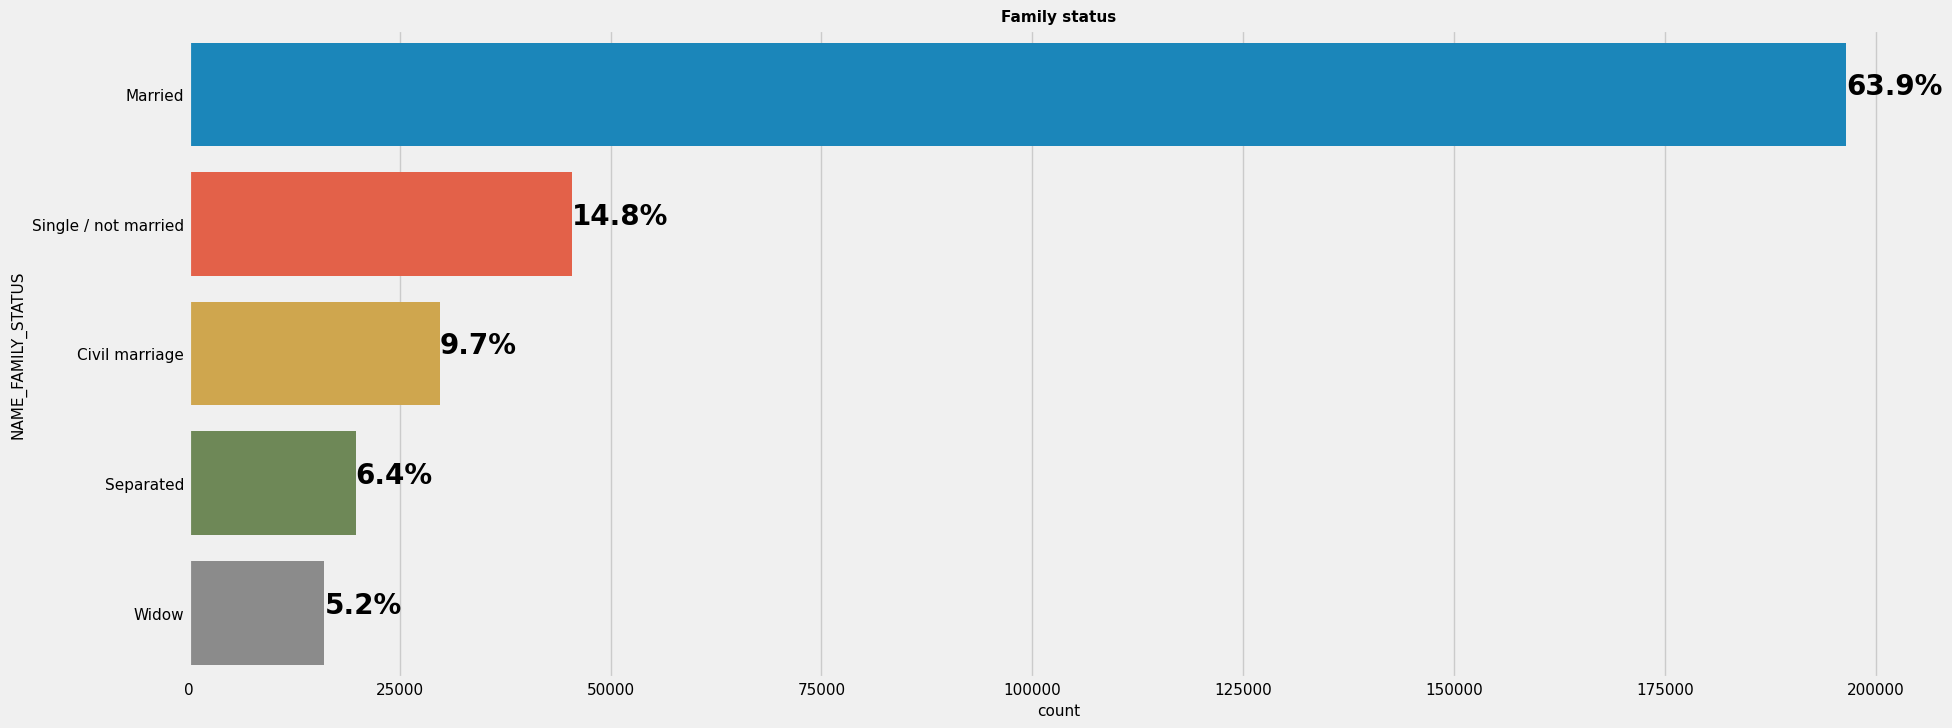

                                   -------------------------------------------------------


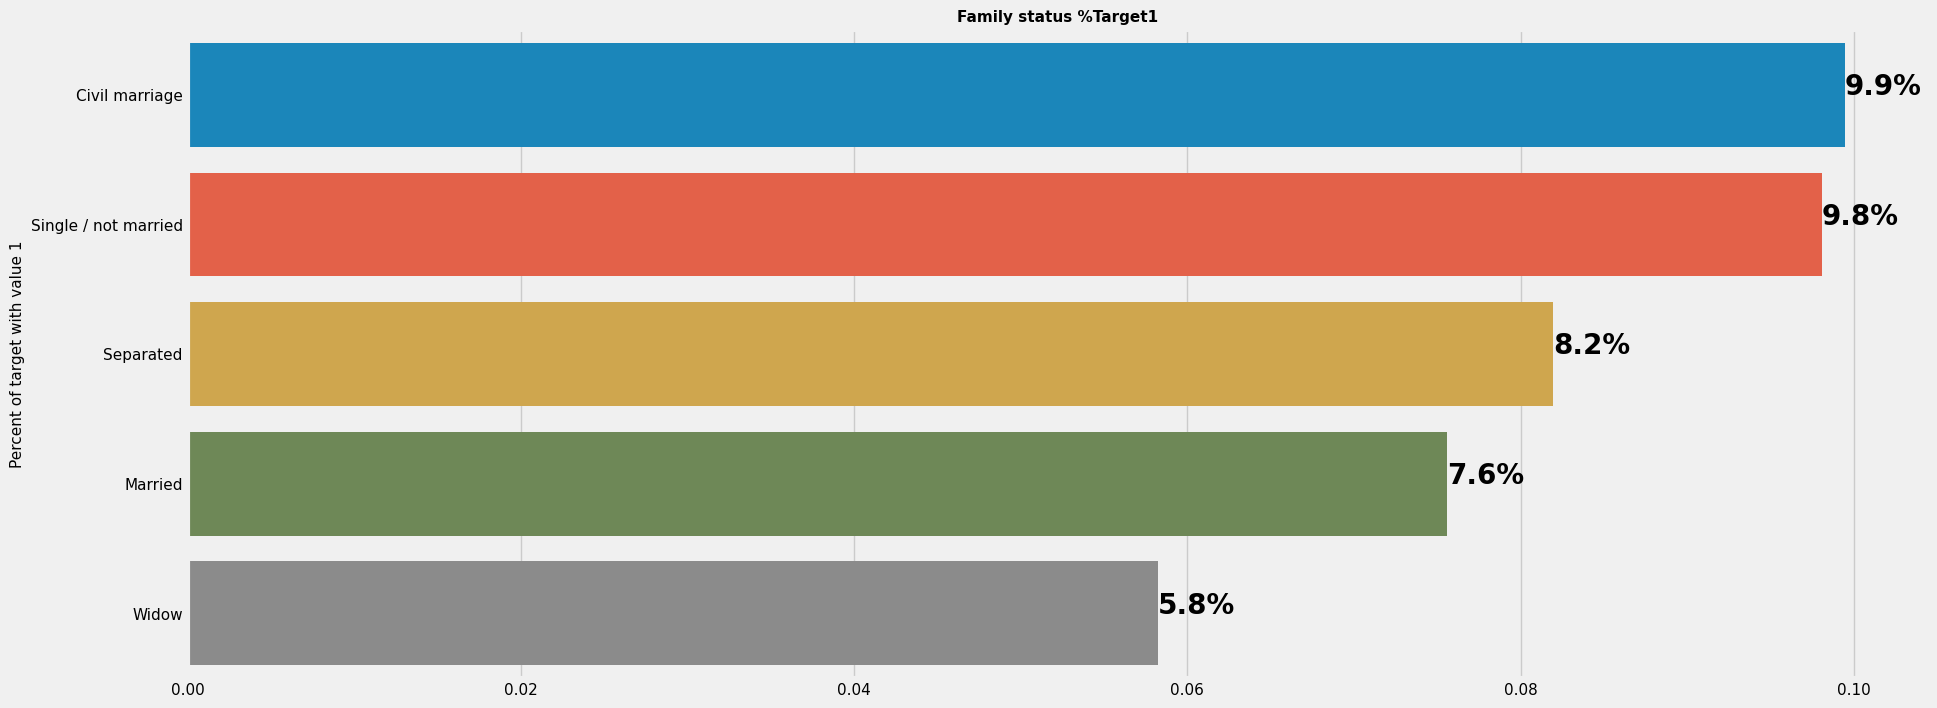

In [34]:
#NAME_FAMILY_STATUS
plot_stat(application_train, 'NAME_FAMILY_STATUS',"Family status")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_FAMILY_STATUS',"Family status %Target1")

La plupart des clients sont mariés, suivis des célibataires / non mariés et des mariages civils.

En termes de pourcentage de non-remboursement du prêt, le mariage civil a le pourcentage le plus élevé de non-remboursement (10%), la veuve étant le plus bas (à l'exception de l'inconnu).

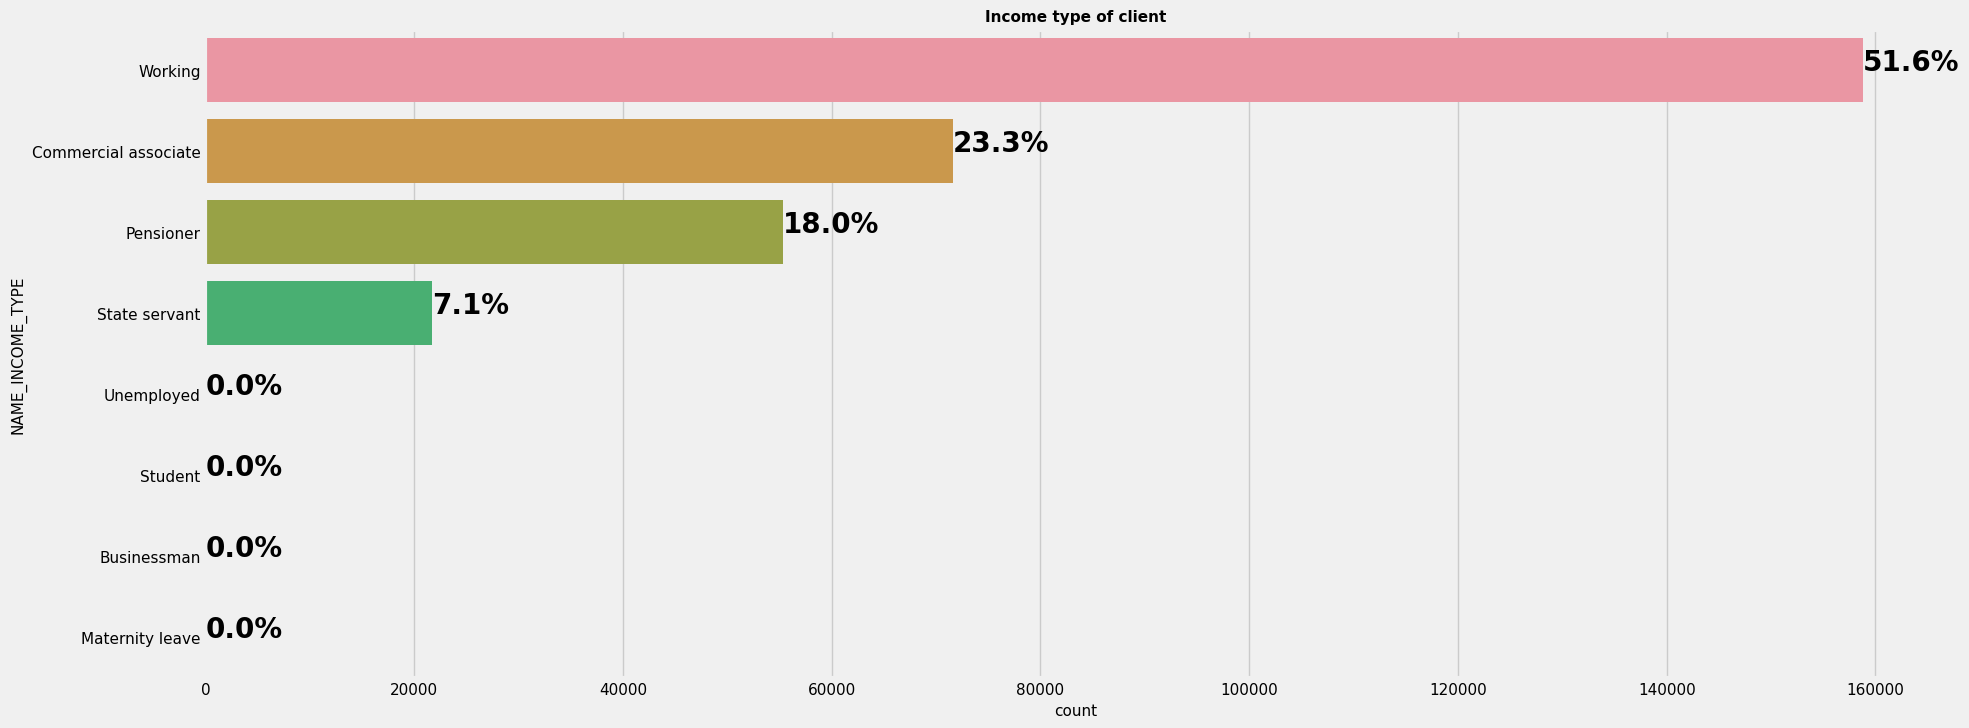

                                   -------------------------------------------------------


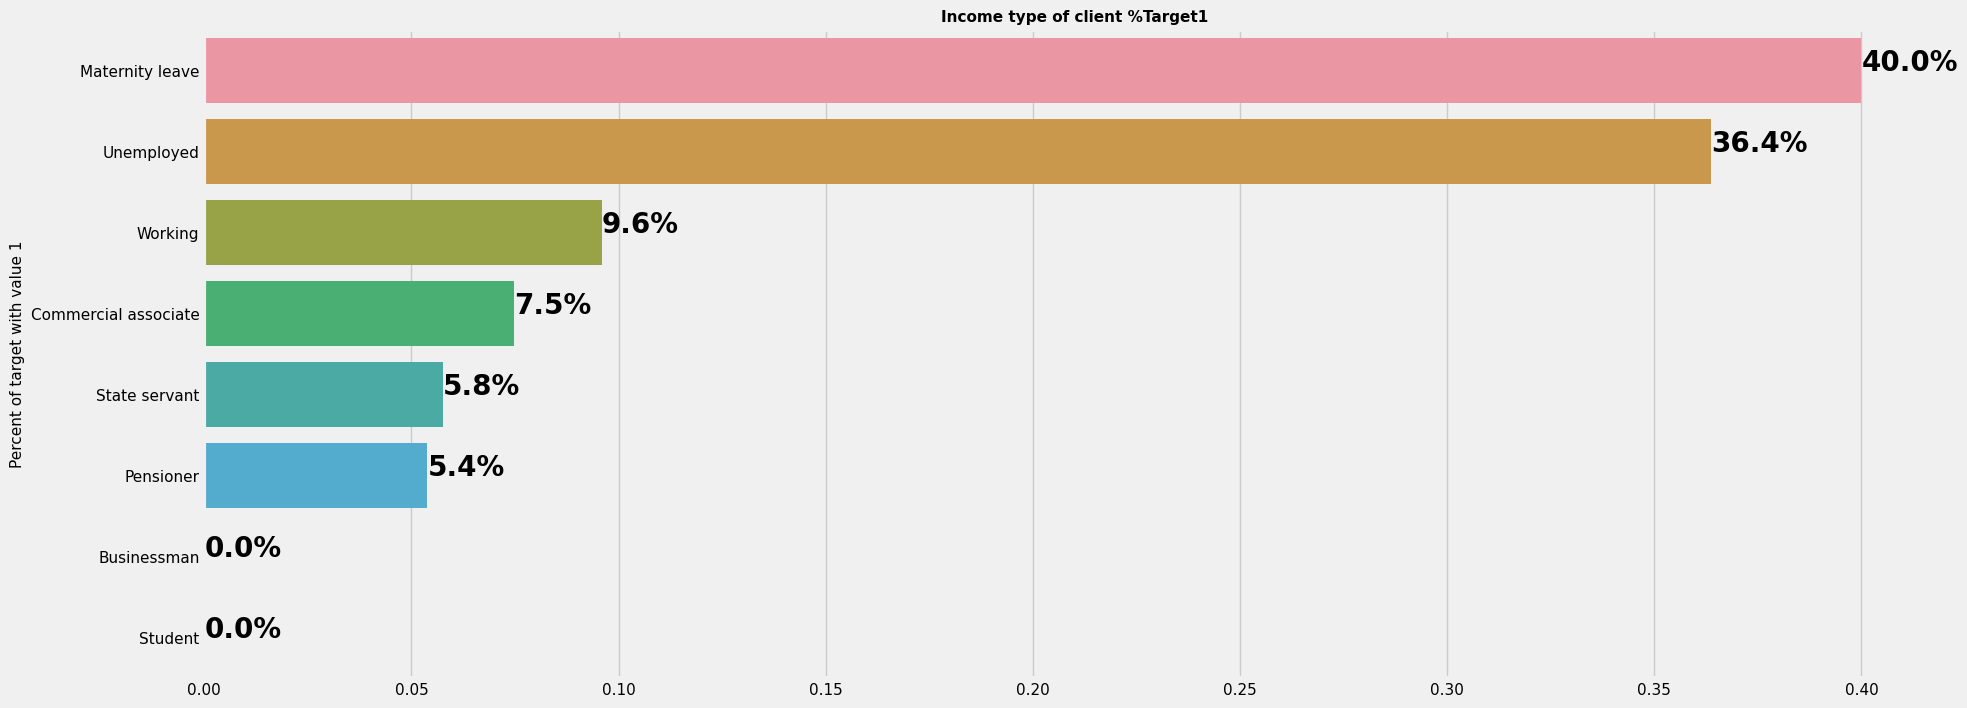

In [35]:
#NAME_INCOME_TYPE
plot_stat(application_train, 'NAME_INCOME_TYPE',"Income type of client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_INCOME_TYPE',"Income type of client %Target1")

La plupart des demandeurs de prêts sont des revenus du travail, suivis par un associé commercial, un retraité et un fonctionnaire.

Les demandeurs avec le type de revenu Congé de maternité ont un ratio de près de 40% de prêts non remboursés, suivis des chômeurs (37%). Les autres types de revenus sont inférieurs à la moyenne de 10% pour ne pas rembourser les prêts.

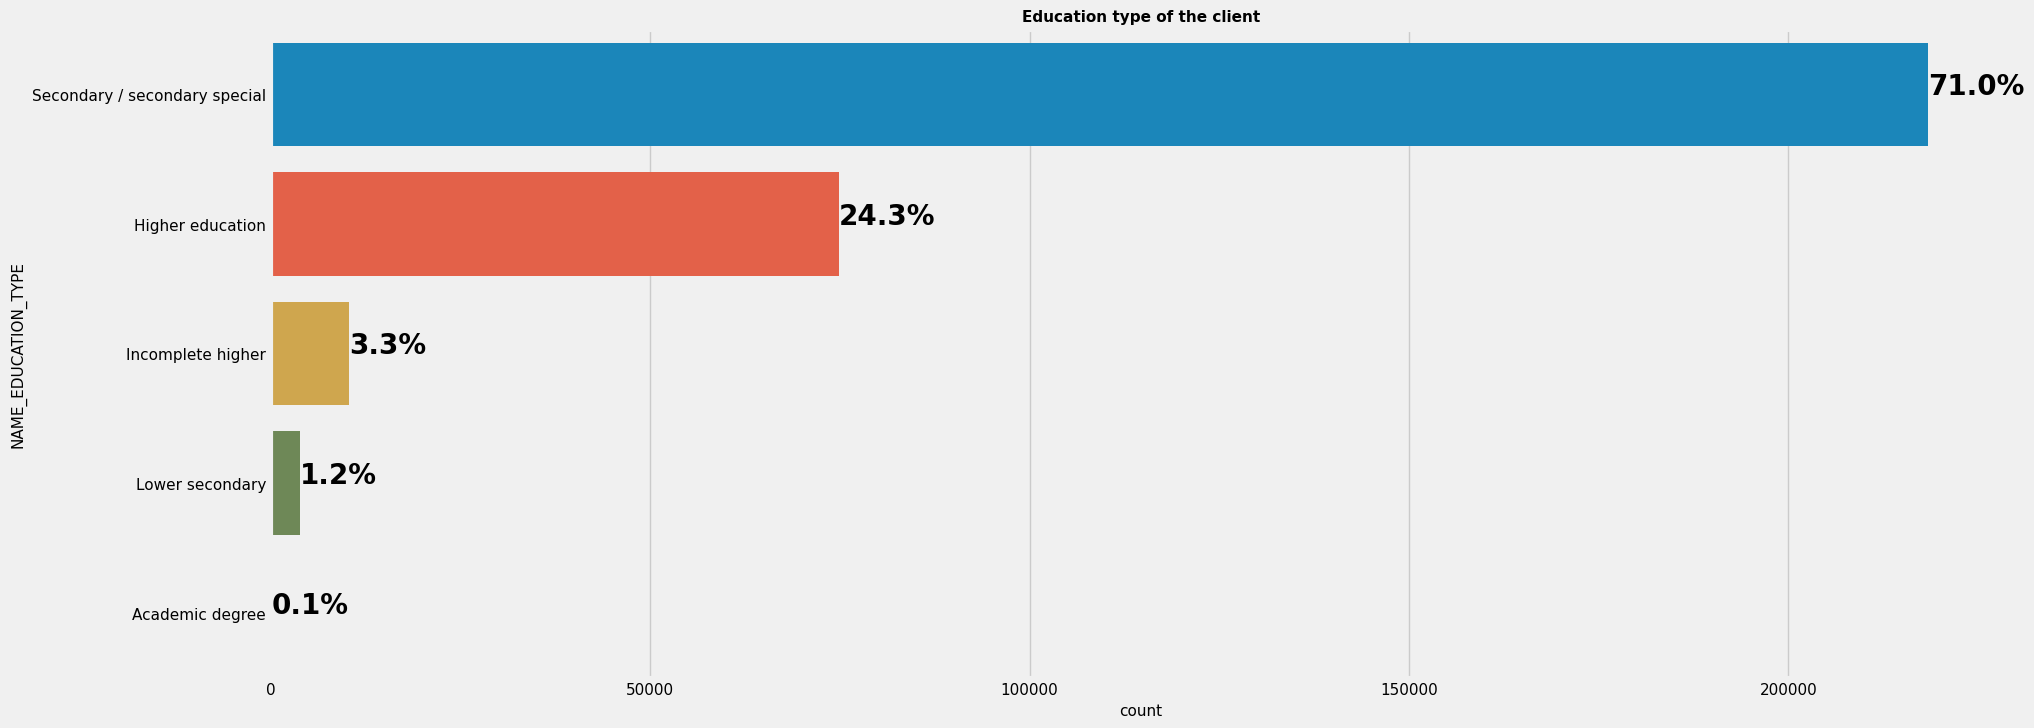

                                   -------------------------------------------------------


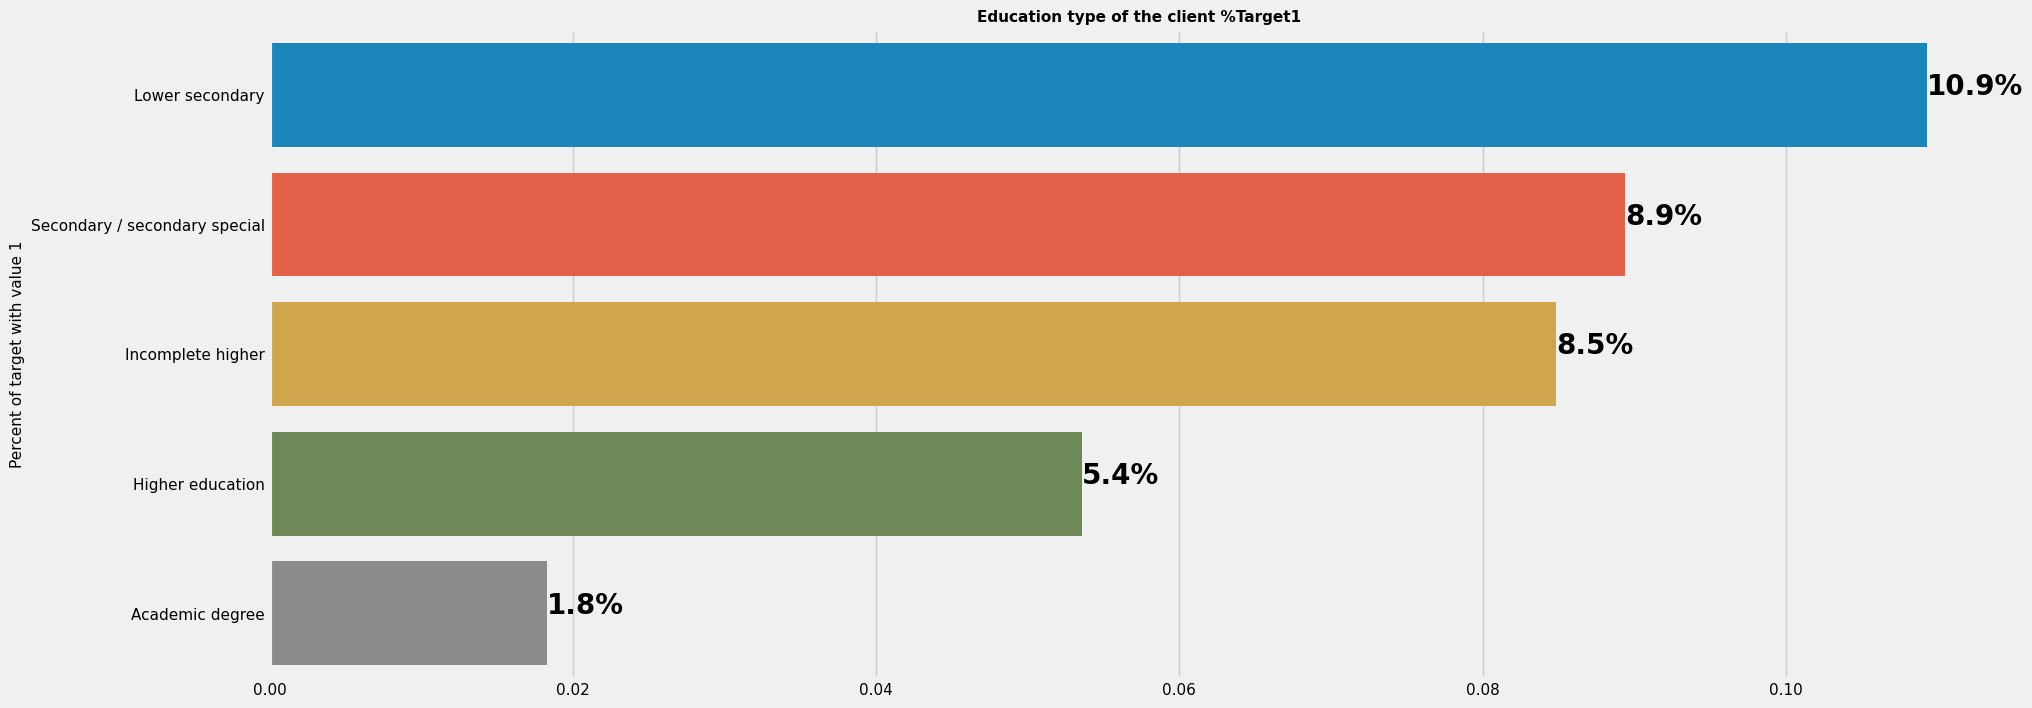

In [36]:
#NAME_EDUCATION_TYPE
plot_stat(application_train, 'NAME_EDUCATION_TYPE',"Education type of the client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_EDUCATION_TYPE',"Education type of the client %Target1")

La majorité des clients sont allés jusqu'au secondaire, suivis des clients avec une éducation supérieure. Un très petit nombre d'emprunteur possède un diplôme universitaire.

La catégorie du premier cycle du secondaire, bien que rare, a le taux le plus élevé de non-remboursement du prêt (11%). Les personnes ayant un diplôme universitaire ont un taux de non-remboursement inférieur à 2%.

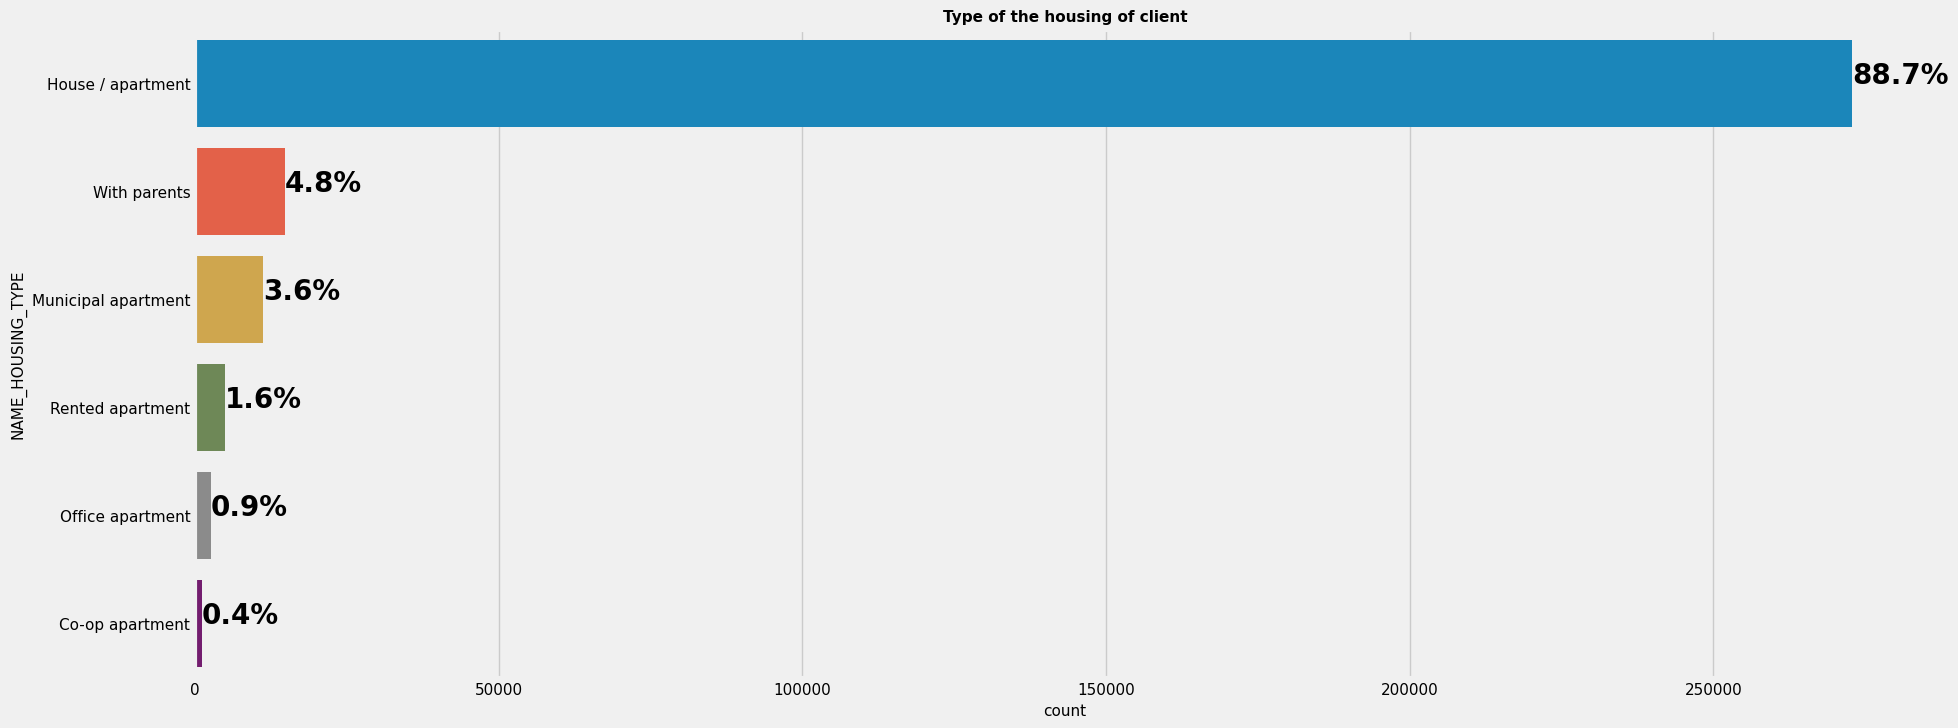

                                   -------------------------------------------------------


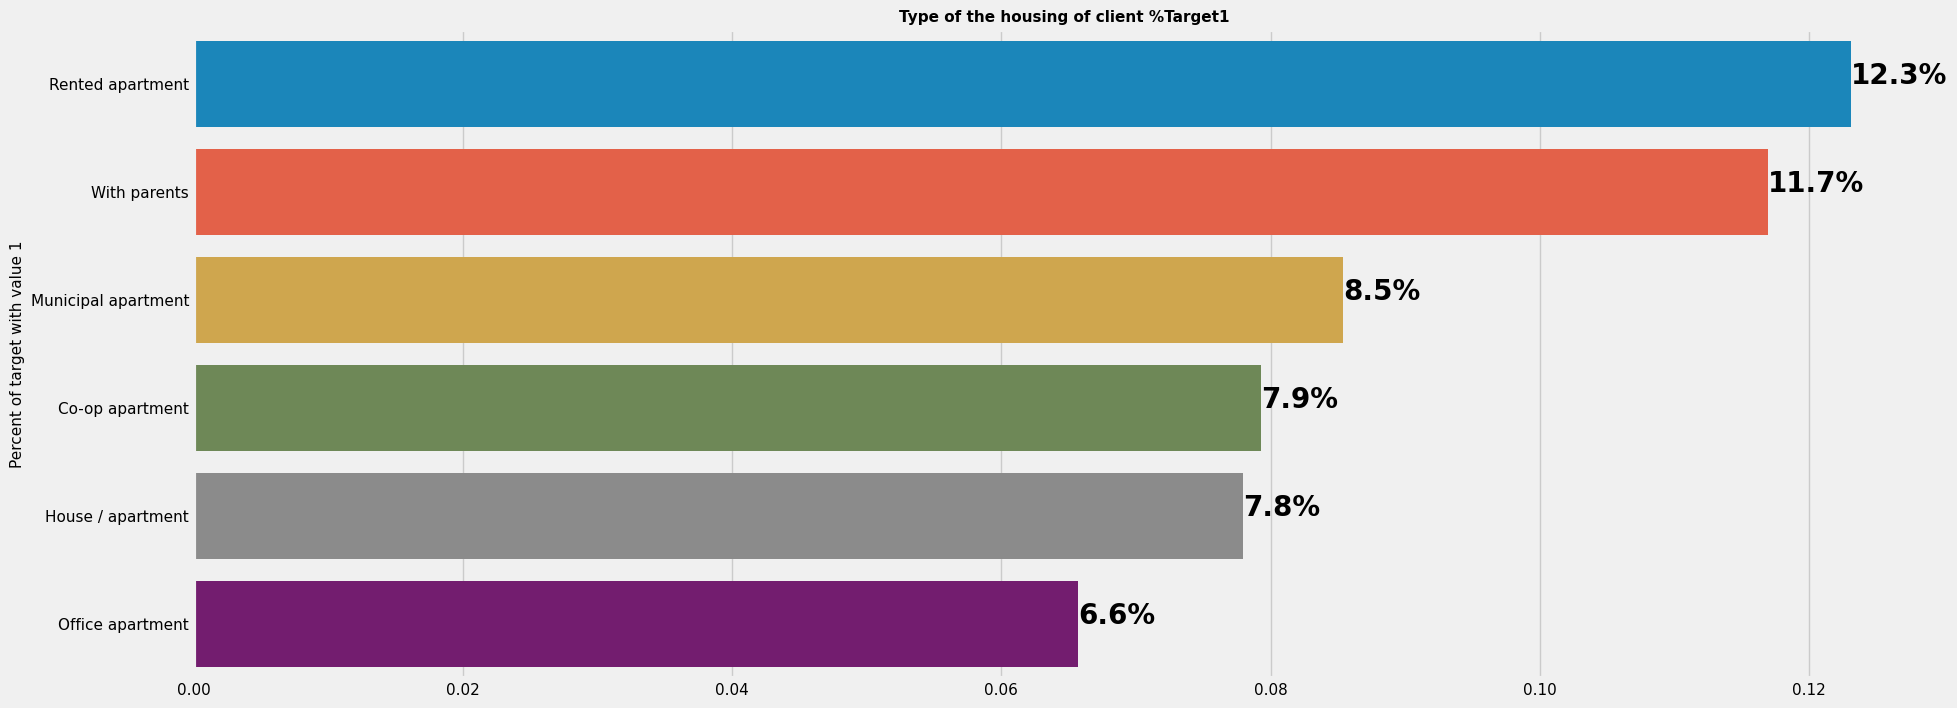

In [37]:
#NAME_HOUSING_TYPE
plot_stat(application_train, 'NAME_HOUSING_TYPE',"Type of the housing of client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_HOUSING_TYPE',"Type of the housing of client %Target1")

Plus de 250 000 demandeurs de crédits vivent en maison ou appartement. Les catégories suivantes, faible pourcentage, représentent une population moins "indépendante" (vivre chez ses parents, etc…).

Dans ces catégories, les loueurs d'appartements (non propriétaires de leur résidence principale), ainsi que ceux qui vivent chez leurs parents, ont un taux de non-remboursement supérieur à 10%.

### Corrélations
L'analyse peut continuer par une étape de traitement des corrélations entre les caractéristiques et la Target. L'idée est de calculer le coefficient de corrélation de Pearson entre chaque variable et la Target. Cette étape permet d'avoir un aperçu des relations possibles entre les variables.

In [38]:
#Display correlations
print('Most Positive Correlations:\n', application_train.corr()['TARGET'].sort_values().tail(15))
print("--------------------------")
print('Most Negative Correlations:\n', application_train.corr()['TARGET'].sort_values().head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
--------------------------
Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_OUTLIERS       -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRI

Notons que la corrélation la plus forte est celle de la variable 'DAYS_BIRTH'. Ceci étant, pour faciliter la compréhension et retrouver la logique vue en préambule, les jours exprimés en valeurs négatives peuvent être traités en valeurs absolues. Alors le coef. de Person sera négatif, cela expose le fait qu'un client plus âgé sera moins susceptible de faire défaut au remboursement de son crédit (cela peut sembler logique, en tout cas ce n'est pas absurde).

In [39]:
#Find the correlation of the positive days since birth and target
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

-0.0782393083098269

En termes de distribution des âges elle peut uniquement servir à visualiser la non présence d'outliers, suite à ce qui a été fait en amont sur les valeurs négatives de départ. Pour visualiser l'effet de l'âge sur la Target, nous pouvons faire un graphique (KDE) coloré par la valeur TARGET 0 et 1.

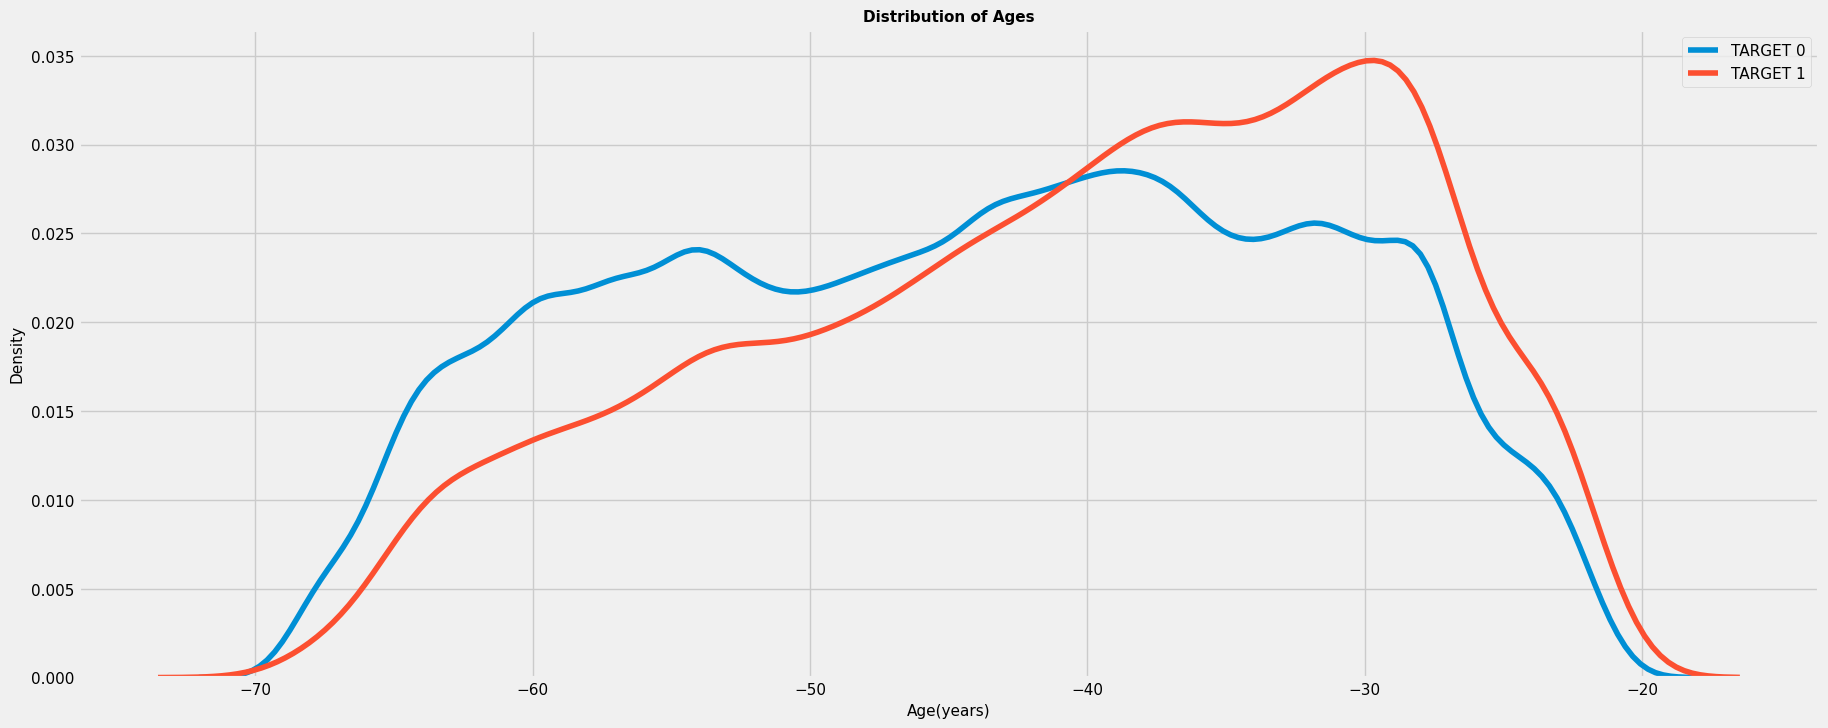

In [40]:
plt.figure(figsize = (20, 8))
sns.kdeplot(application_train[application_train['TARGET'] == 0]['DAYS_BIRTH'] / -365, label = 'TARGET 0')
sns.kdeplot(application_train[application_train['TARGET'] == 1]['DAYS_BIRTH'] / -365, label = 'TARGET 1')

plt.legend(), plt.xlabel('Age(years)'), plt.ylabel('Density'), plt.title('Distribution of Ages')
plt.show()

La courbe cible TARGET 1 s'incline vers l'extrémité la plus jeune de la plage. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient Pearson -0,07), cette variable sera probablement utile dans un modèle d'apprentissage car elle affecte la Target.

#### Sources extérieures, les plus fortes corrélations linéaires…
Ces 3 variables (EXT_SOURCE) présentant les corrélations négatives les plus fortes avec la Target. Selon la documentation, ces fonctionnalités représentent un «score normalisé à partir d'une source de données externe». 
Difficile de comprendre le sens exact, nous pouvons émettre l'hypothèse d'une cote de crédit cumulative établie à l'aide de différentes sources de données.

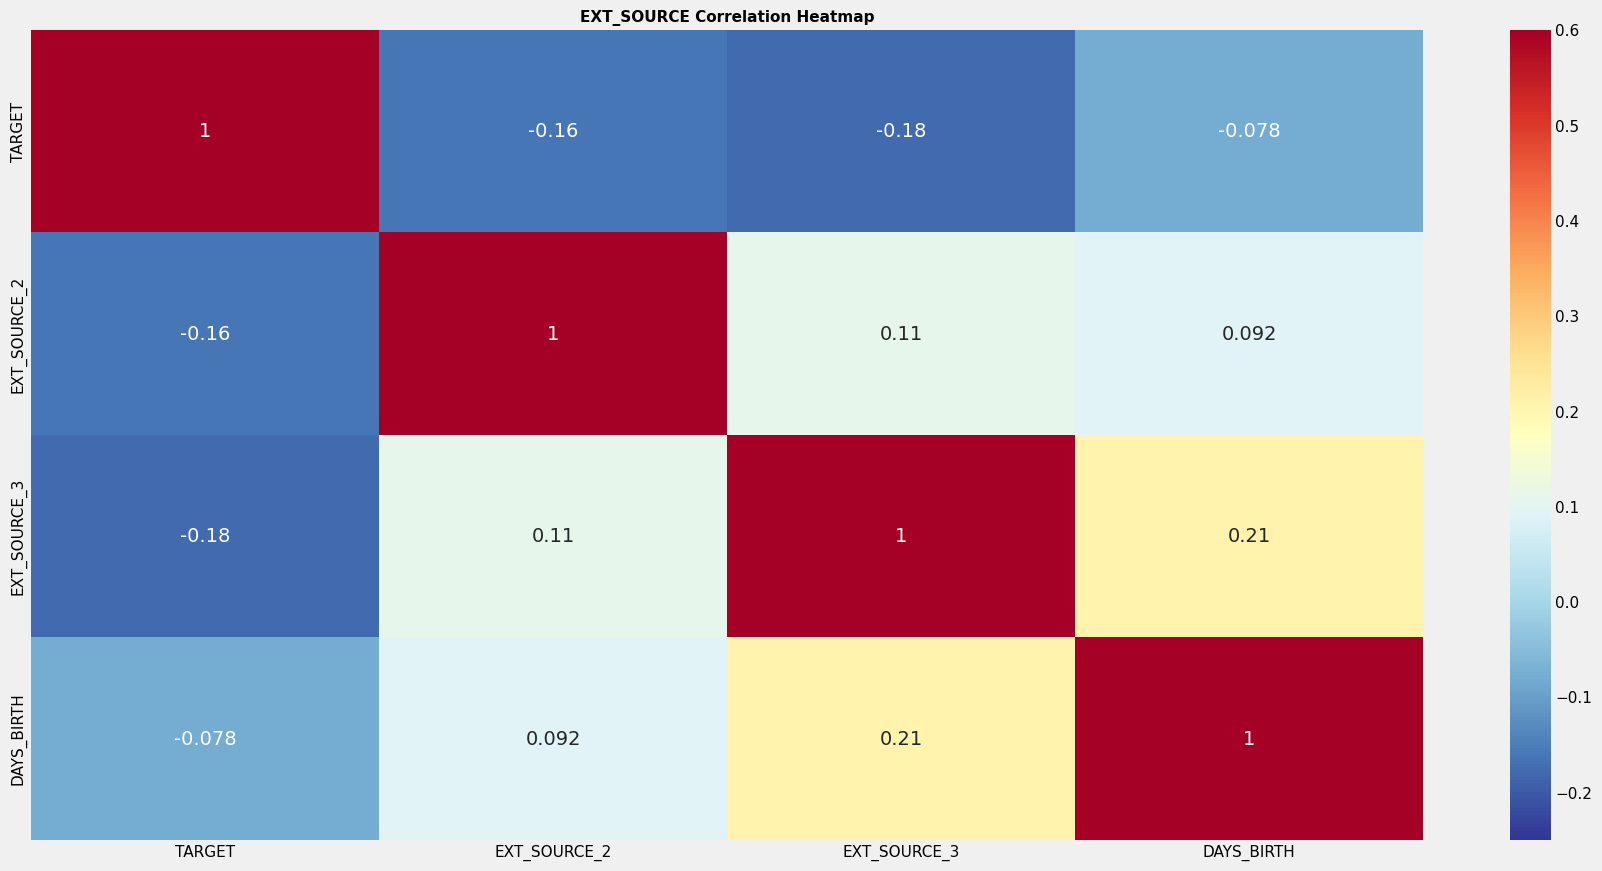

In [41]:
#Heatmap of correlations
plt.figure(figsize = (20,10))
sns.heatmap(application_train[['TARGET', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
           )
plt.title('EXT_SOURCE Correlation Heatmap')
plt.show()

Ces sources extérieures sont corrélées négativement avec la Target (Attention, négativement mais avec de très faibles coefficients). Malgré tout, on peut penser que si la valeur augmente, le client est plus susceptible de pouvoir rembourser le crédit.

In [42]:
#Plot distribution of one feature
def plot_distribution(feature, title):
    plt.figure(figsize=(20,6))

    t0 = application_train.loc[application_train['TARGET'] == 0]
    t1 = application_train.loc[application_train['TARGET'] == 1]

    
    sns.kdeplot(t0[feature].dropna(), color='blue', label="TARGET = 0")
    sns.kdeplot(t1[feature].dropna(), color='red', label="TARGET = 1")
    plt.title(title)
    plt.ylabel('')
    plt.legend()
    plt.show()   

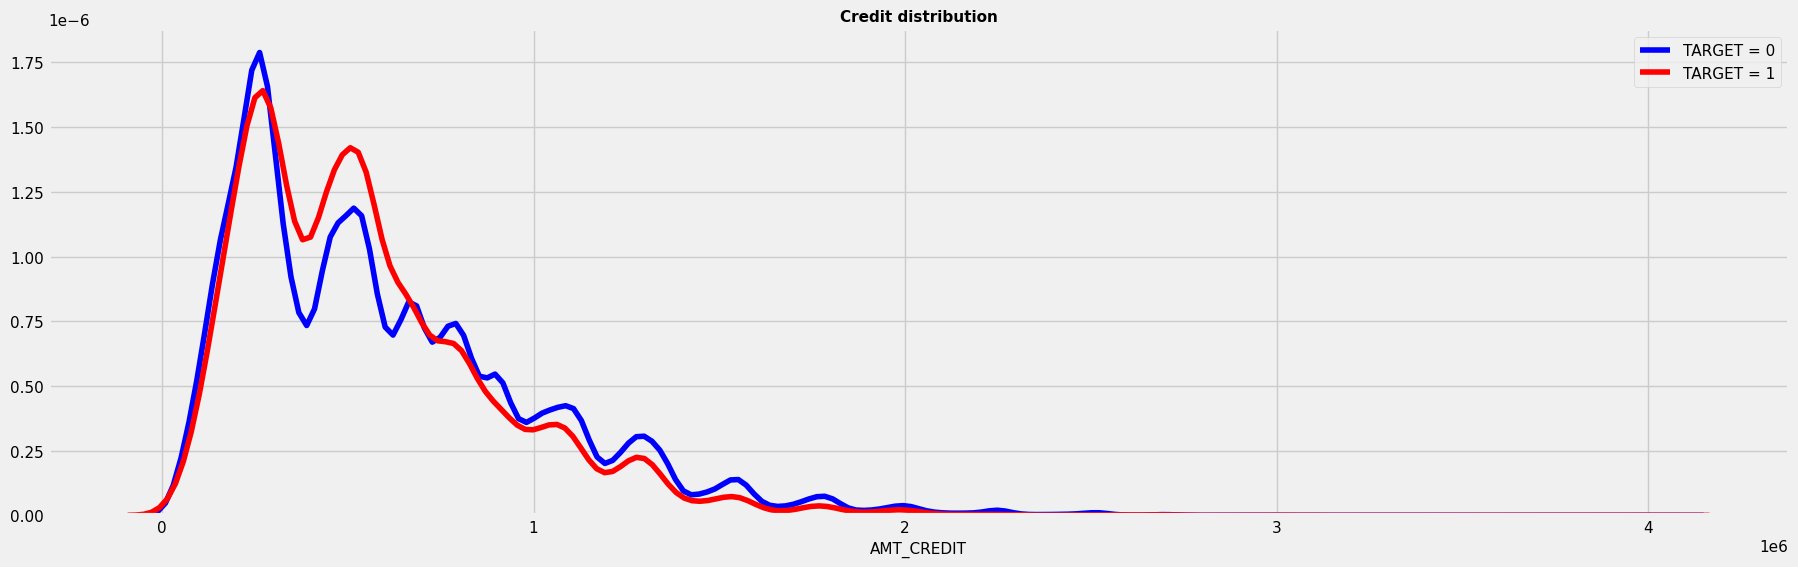

                                   -------------------------------------------------------


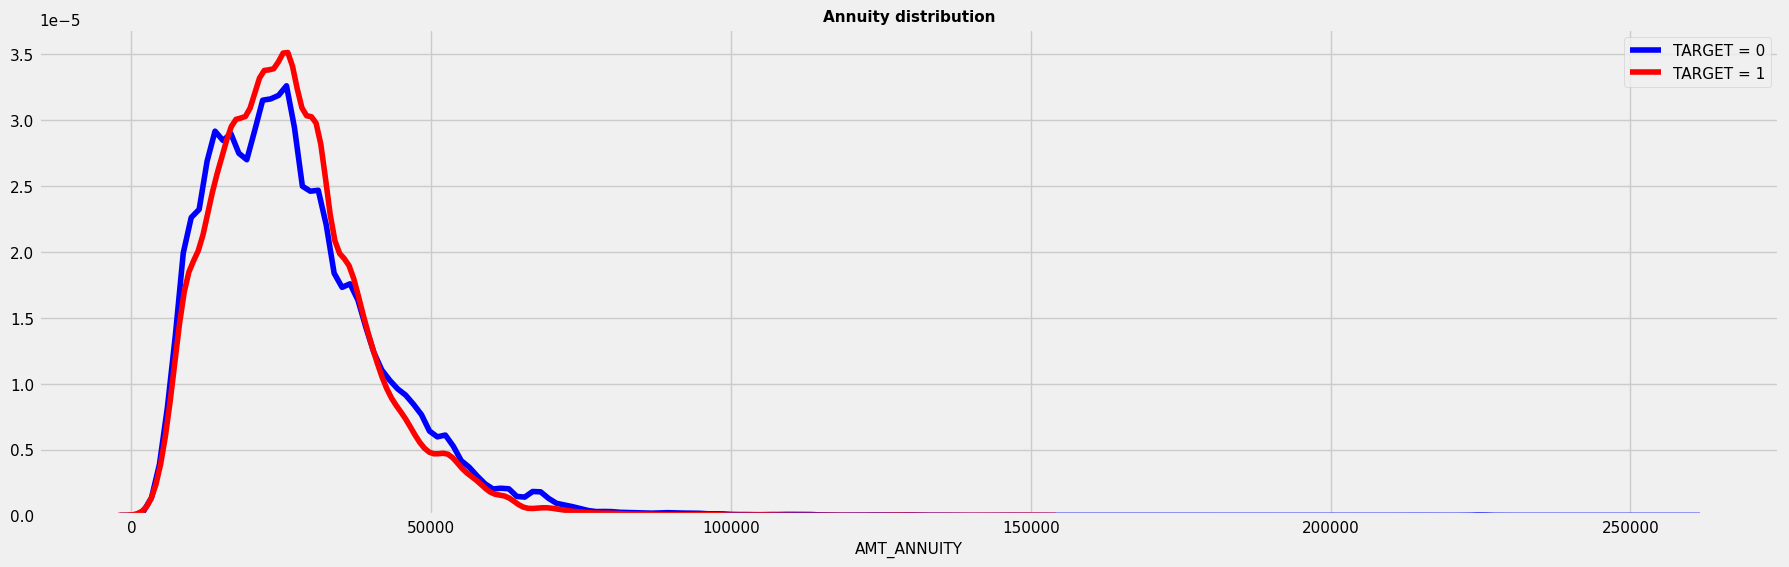

                                   -------------------------------------------------------


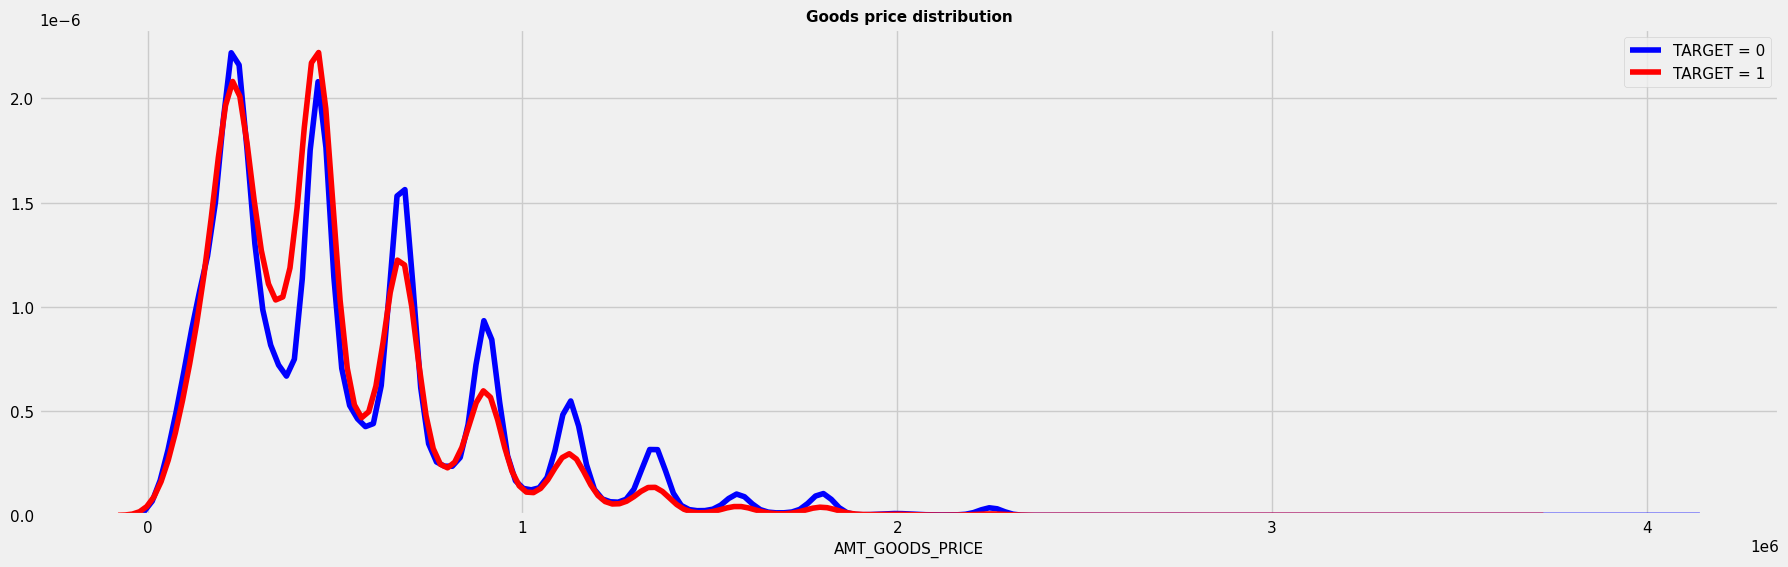

                                   -------------------------------------------------------


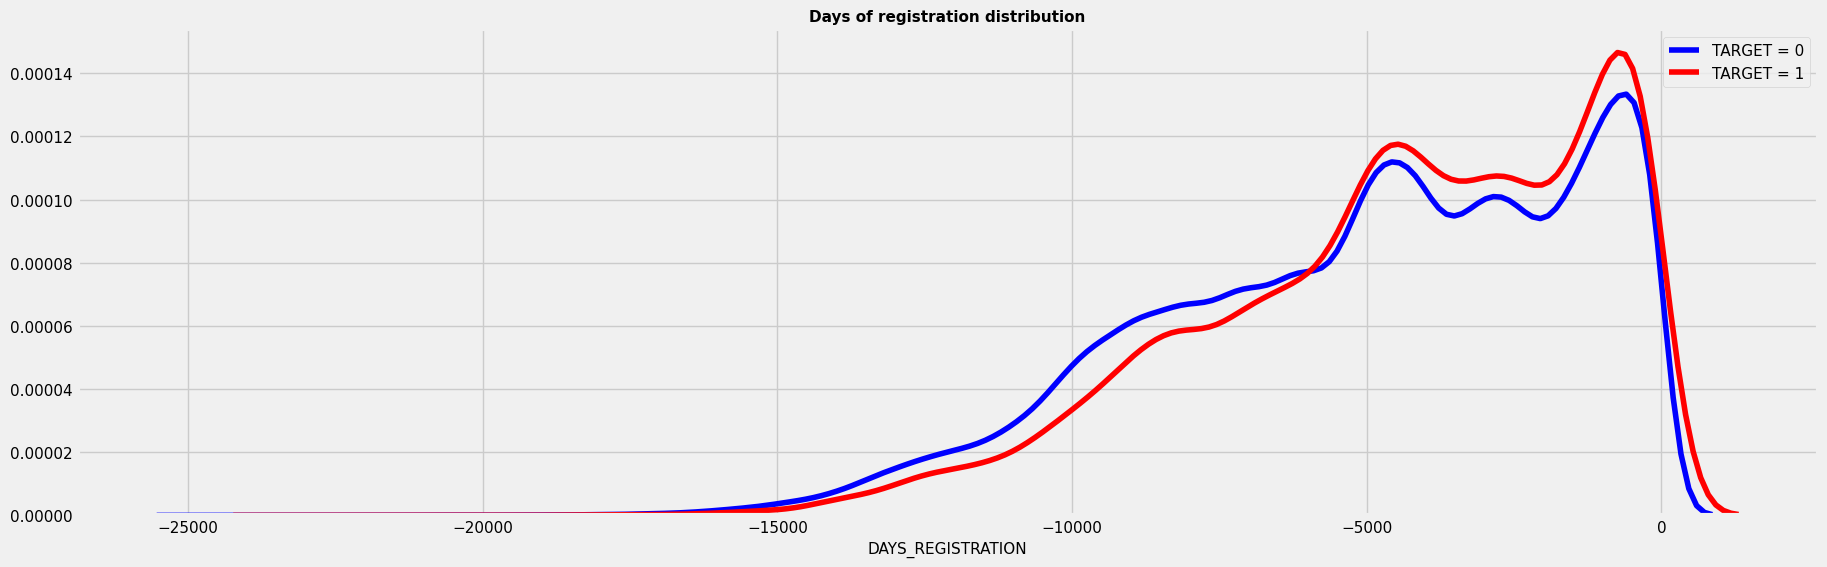

                                   -------------------------------------------------------


In [43]:
plot_distribution('AMT_CREDIT', "Credit distribution")
print("                                   -------------------------------------------------------")
plot_distribution('AMT_ANNUITY', "Annuity distribution")
print("                                   -------------------------------------------------------")
plot_distribution('AMT_GOODS_PRICE', "Goods price distribution")
print("                                   -------------------------------------------------------")
plot_distribution('DAYS_REGISTRATION', "Days of registration distribution")
print("                                   -------------------------------------------------------")

Calcul du nombre total des précédents crédits pris par chaque client. Ce type d'information viendra enrichir l'échantillon de travail… 

In [44]:
#Total number of previous credits taken by each customer
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
                                       columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()

,SK_ID_CURR,PREVIOUS_LOANS_COUNT
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [45]:
#Merge this new column in our df_train_without_corr
application_train = application_train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
application_train.shape

(307511, 124)

``bureau_balance : bureau_balance.csv``

In [46]:
display(bureau_balance.head())
display(bureau_balance.shape)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


(27299925, 3)

In [47]:
#Monthly average balances of previous credits in Credit Bureau.
bureau_bal_mean = bureau_balance.groupby('SK_ID_BUREAU', as_index=False).mean().rename(columns = 
                                        {'MONTHS_BALANCE': 'MONTHS_BALANCE_MEAN'})
bureau_bal_mean.head()

,SK_ID_BUREAU,MONTHS_BALANCE_MEAN
0,5001709,-48.0
1,5001710,-41.0
2,5001711,-1.5
3,5001712,-9.0
4,5001713,-10.5


In [48]:
bureau_full = bureau.merge(bureau_bal_mean, on='SK_ID_BUREAU', how='left')
bureau_full.drop('SK_ID_BUREAU', axis=1, inplace=True)
display(bureau_full.head())
display(bureau_full.shape)

,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MEAN
0,215354,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN
2,215354,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN
3,215354,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN
4,215354,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN


(1716428, 17)

In [49]:
bureau_mean = bureau_full.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_BUR_MEAN_')
bureau_mean = bureau_mean.rename(columns = {'PREV_BUR_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})
bureau_mean.shape

(305811, 14)

In [50]:
#Merge all this features with bureau
bureau = bureau.merge(bureau_mean, on='SK_ID_CURR', how='left')
bureau.shape

(1716428, 30)

``previous_application``

Comme précédemment, commençons par quantifier le nombre de demandes précédentes des clients au crédit immobilier et ajoutons cette données à l'échantillon.

In [51]:
#Number of previous applications of the clients to Home Credit
previous_application_counts = previous_application.groupby('SK_ID_CURR', 
                                                           as_index=False)['SK_ID_PREV'].count().rename(
                                                           columns = {'SK_ID_PREV': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts.head()

,SK_ID_CURR,PREVIOUS_APPLICATION_COUNT
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [52]:
#Merge this new column in our data previous_application
previous_application = previous_application.merge(previous_application_counts, on='SK_ID_CURR', how='left')
previous_application.shape

(1670214, 38)

### Traitement des valeurs manquantes:

Je supprime les colonnes ayant plus de 50% de valeurs manquantes. 

In [53]:
application_test.drop(application_train.columns[application_train.isnull().mean()>0.5],axis=1, inplace=True)
application_train.drop(application_train.columns[application_train.isnull().mean()>0.5],axis=1, inplace=True)

In [54]:
print(application_train.shape)
print(application_test.shape)

(307511, 83)
(48744, 81)


In [55]:
application_train.dtypes.value_counts()

int64      40
float64    29
object     13
bool        1
dtype: int64

Après suppression des variables contenant plus de 50% de valeurs manquantes il nous reste 13 variables catégorielles et\
69 variables numériques.

In [56]:
application_train.isna().mean().sort_values(ascending = False)

FLOORSMAX_MEDI                  0.497608
FLOORSMAX_MODE                  0.497608
FLOORSMAX_AVG                   0.497608
YEARS_BEGINEXPLUATATION_MEDI    0.487810
YEARS_BEGINEXPLUATATION_MODE    0.487810
YEARS_BEGINEXPLUATATION_AVG     0.487810
TOTALAREA_MODE                  0.482685
EMERGENCYSTATE_MODE             0.473983
OCCUPATION_TYPE                 0.313455
EXT_SOURCE_3                    0.198253
DAYS_EMPLOYED                   0.180072
ORGANIZATION_TYPE               0.180072
PREVIOUS_LOANS_COUNT            0.143149
AMT_REQ_CREDIT_BUREAU_YEAR      0.135016
AMT_REQ_CREDIT_BUREAU_QRT       0.135016
AMT_REQ_CREDIT_BUREAU_MON       0.135016
AMT_REQ_CREDIT_BUREAU_WEEK      0.135016
AMT_REQ_CREDIT_BUREAU_DAY       0.135016
AMT_REQ_CREDIT_BUREAU_HOUR      0.135016
NAME_TYPE_SUITE                 0.004201
DEF_30_CNT_SOCIAL_CIRCLE        0.003320
OBS_30_CNT_SOCIAL_CIRCLE        0.003320
DEF_60_CNT_SOCIAL_CIRCLE        0.003320
OBS_60_CNT_SOCIAL_CIRCLE        0.003320
EXT_SOURCE_2    

#### Imputation des valeurs manquantes:

Pour les variables catégorielles on remplacera les valeurs manquantes par la valeur la plus fréquente et pour les variables numériques on utilisera le KNN-Imputer.

In [57]:
# Columns have less 20% NaN Values and categorical for application_test
Cat_columns_lower_percentage_nan  = [i for i in application_train.columns[(application_train.isnull().mean() * 100) < 20] 
                                     if application_train[i].dtype == 'O']

# Columns have less 20% NaN Values and numerical
num_columns_lower_percentage_nan  = [i for i in application_train.columns[(application_train.isnull().mean() * 100) < 20] 
                                     if application_train[i].dtype != 'O']

In [63]:
# Columns have less 20% NaN Values and categorical for application_test
Cat_columns_lower_percentage_nan_test  = [i for i in application_test.columns[(application_test.isnull().mean() * 100) < 20] 
                                     if application_test[i].dtype == 'O']

# Columns have less 20% NaN Values and numerical
num_columns_lower_percentage_nan_test  = [i for i in application_test.columns[(application_test.isnull().mean() * 100) < 20] 
                                     if application_test[i].dtype != 'O']

#### imputation des variables catégorielles:

In [58]:
for col in Cat_columns_lower_percentage_nan:
    application_test[col].fillna(application_train[col].mode()[0], inplace=True)

In [64]:
for col in Cat_columns_lower_percentage_nan_test:
    application_test[col].fillna(application_test[col].mode()[0], inplace=True)   

#### imputation des variables numériques:

In [65]:
for col in num_columns_lower_percentage_nan[2:]:
    application_train[col].fillna(application_train[col].mean(), inplace=True)

In [66]:
for col in num_columns_lower_percentage_nan_test[2:]:
    application_test[col].fillna(application_test[col].mean(), inplace=True)

In [67]:
print("dimension de application train:", application_train.shape)
print("dimension de application test:", application_test.shape)

dimension de application train: (307511, 83)
dimension de application test: (48744, 81)


In [ ]:
col_cat = application_train.select_dtypes('object').columns
print("Nombre de varaibles catégrielles:", len(col_cat[0:]))
col_cat

### Exploration des variables catégorielles:

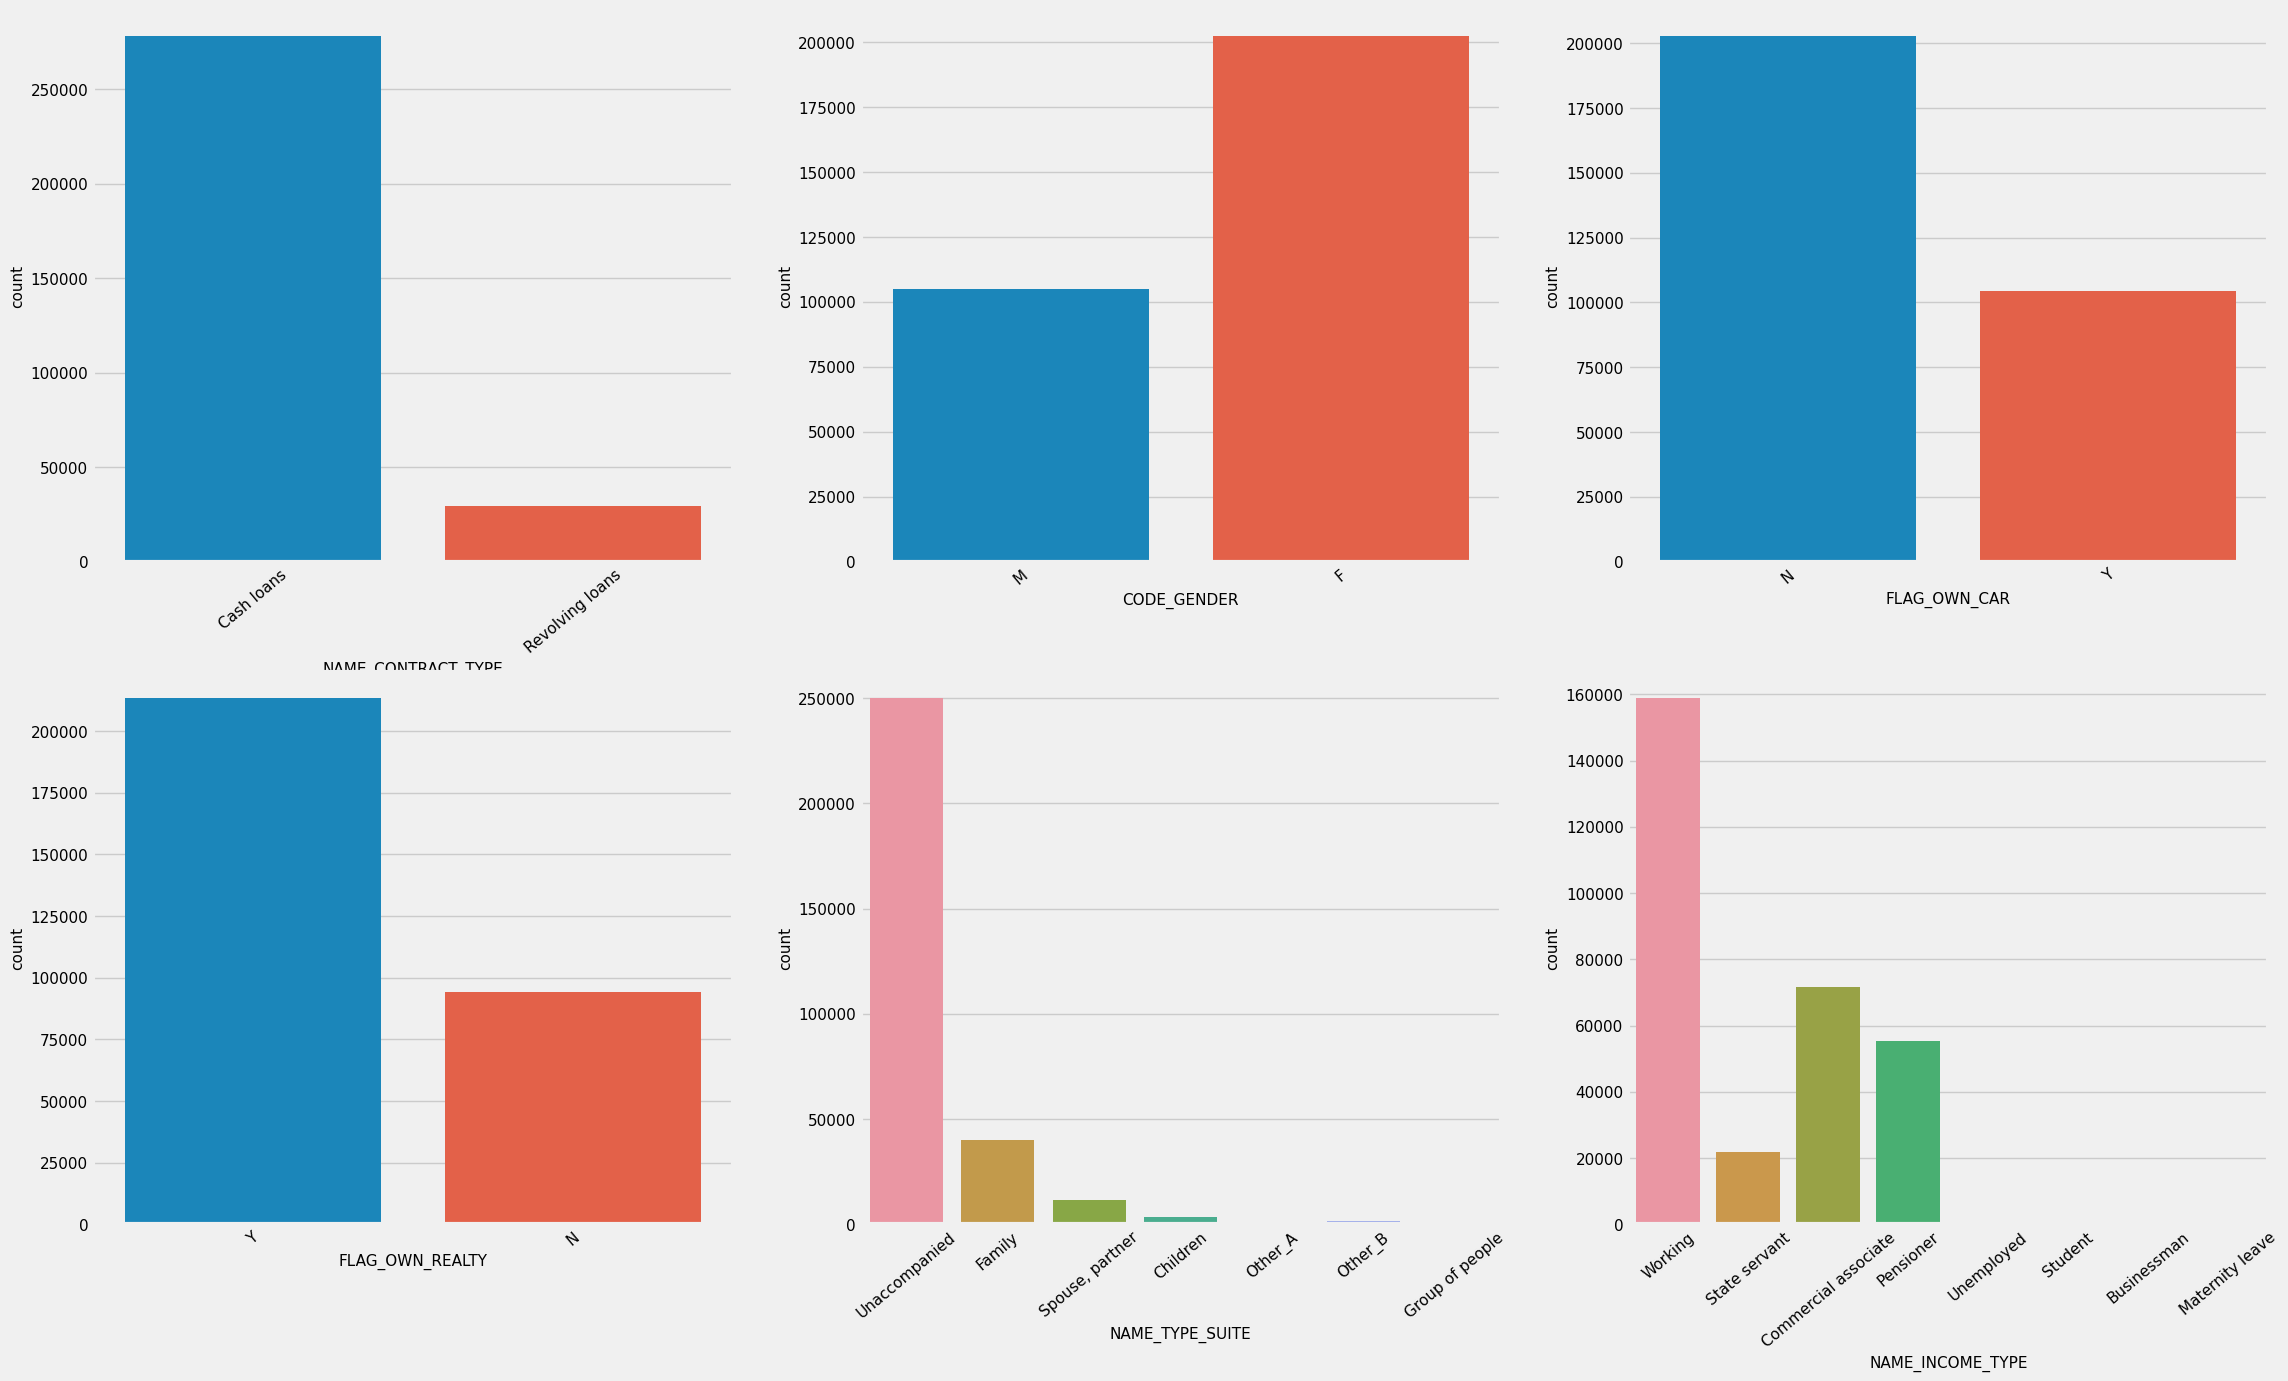

In [68]:
col_cat = application_train.select_dtypes('object').columns
plt.figure(figsize=(25,15))

plt.rcParams.update({'font.size': 15})
for i, col in enumerate(col_cat[0:6]):
    plt.subplot(2,3,i+1)
    sns.countplot(data=application_train, x=col, orient="v")
    plt.xticks(rotation=40)
plt.show()

- D'après le graphique de 'CODE_GENDER, on voit qu'Il y a plus de demande de credit chez les femmes que chez les hommes.
- Et il y a moins de demande de prêt renouvelable.

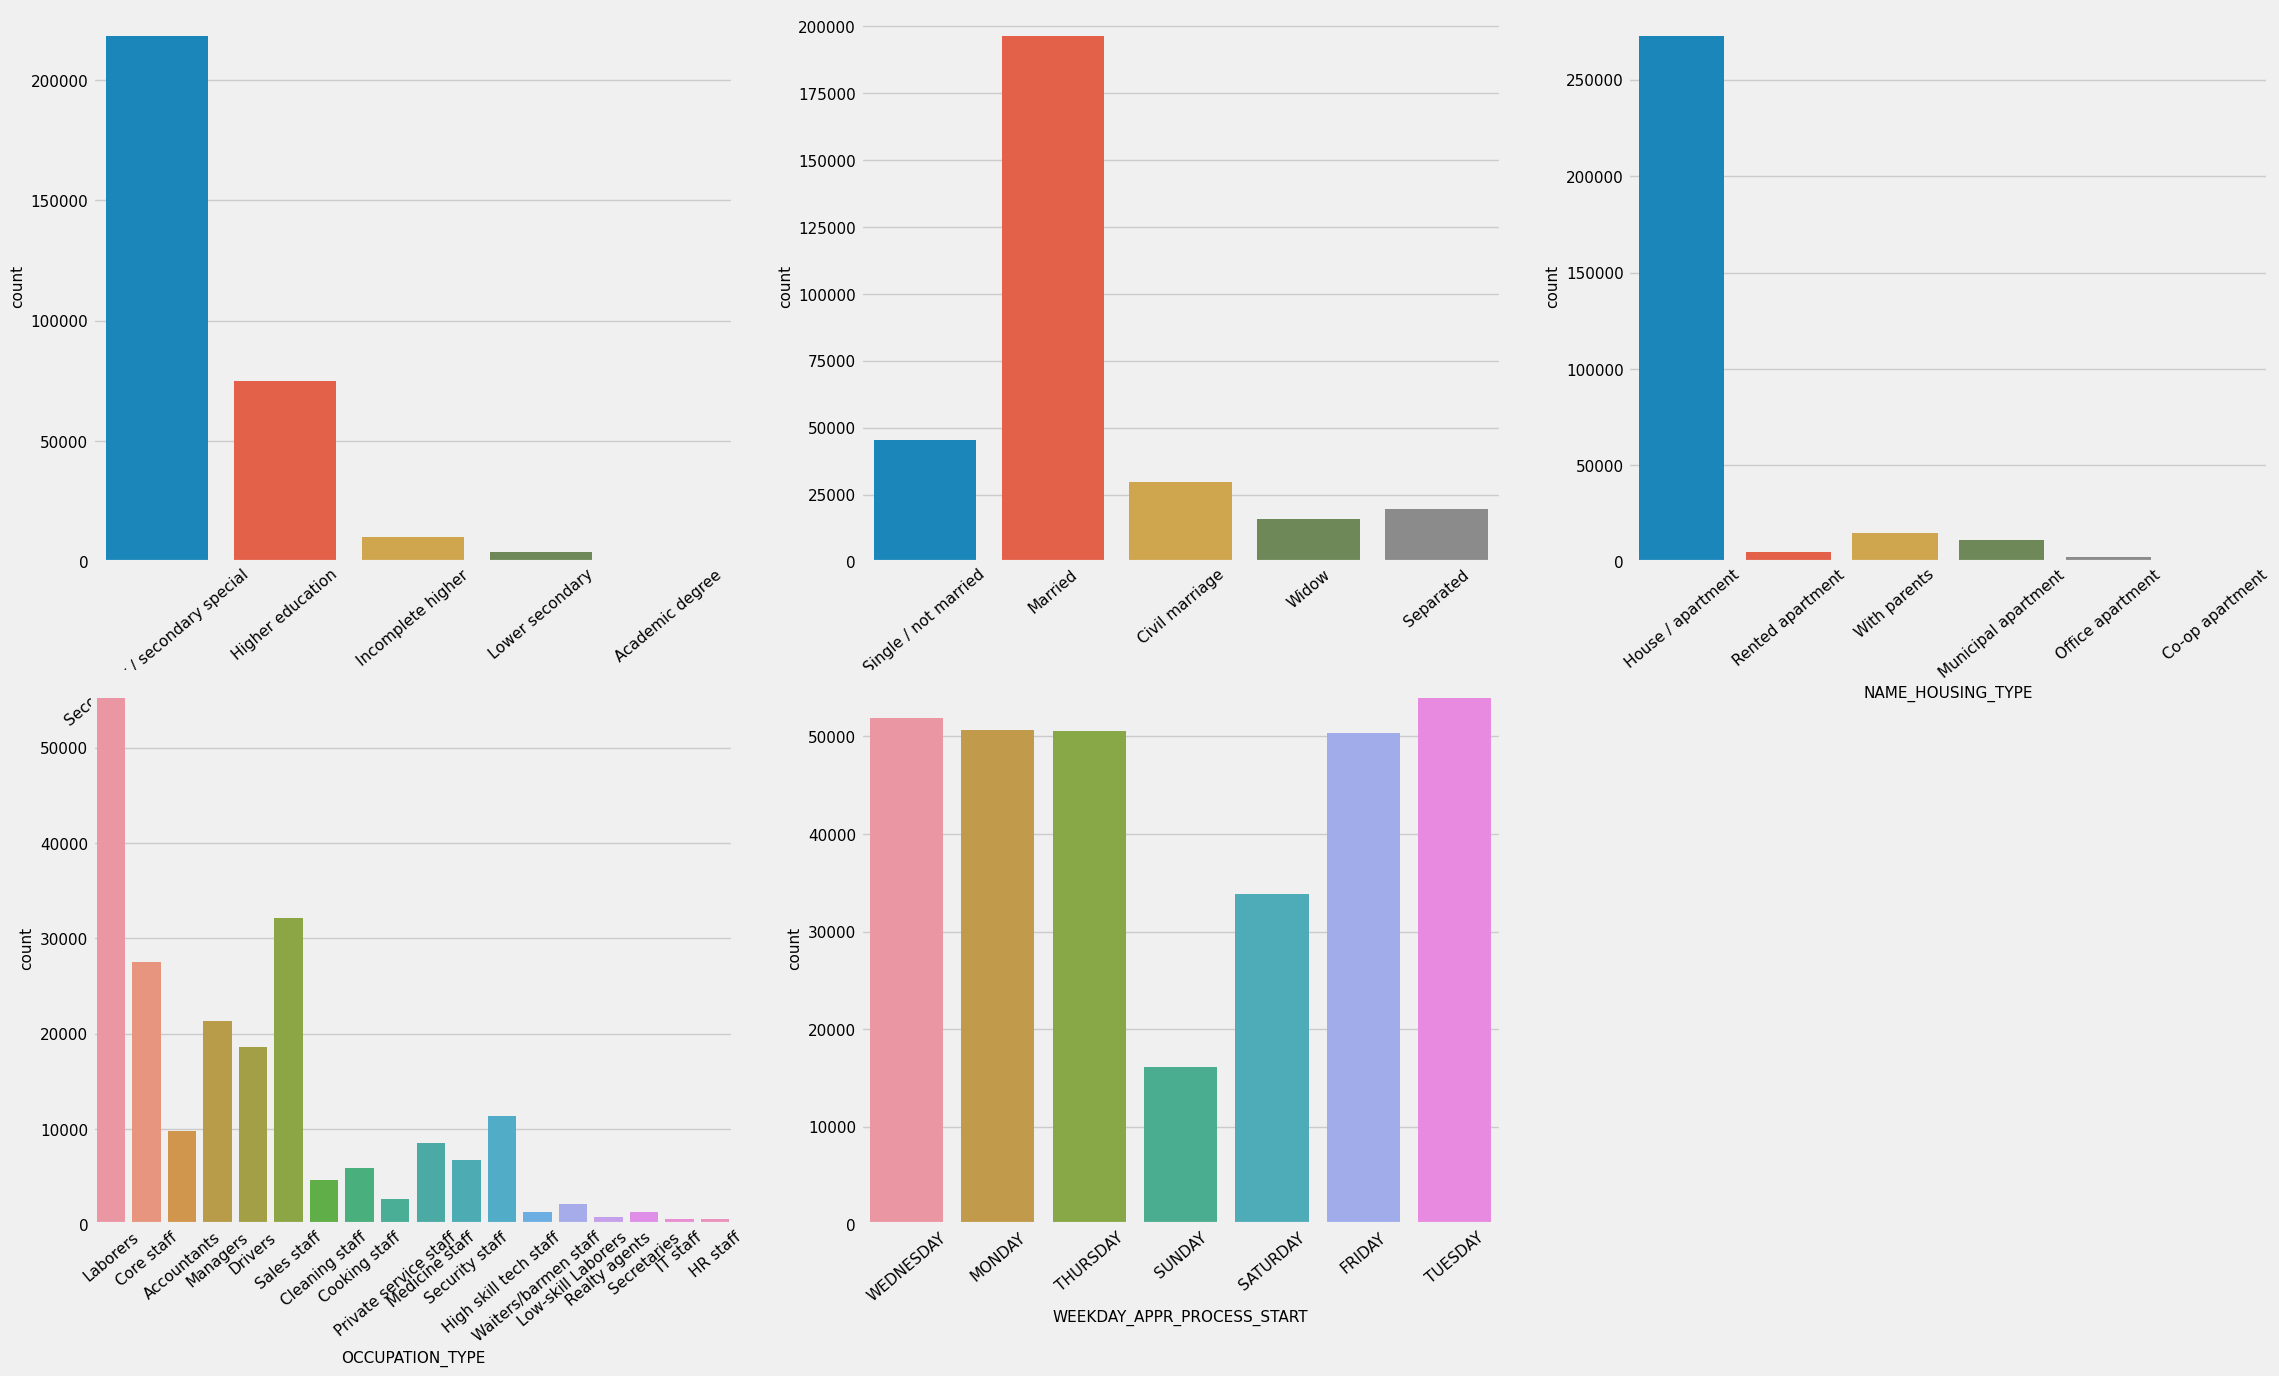

In [69]:
col_cat = application_train.select_dtypes('object').columns
plt.figure(figsize=(25,15))

plt.rcParams.update({'font.size': 15})
for i, col in enumerate(col_cat[6:11]):
    plt.subplot(2,3,i+1)
    sns.countplot(data=application_train, x=col, orient="v")
    plt.xticks(rotation=40)
plt.show()

- Si nous examinons le niveau d'éducation des clients, nous constatons que la majorité des candidats n'ont étudié que jusqu'au     secondaire /secondaire spécial, qui est suivi par l'enseignement supérieur.

- La profession la plus courante parmi les clients est celle des ouvriers, suivie du personnel de vente et du personnel de     base.\
  Et on peut constater qu'il n'y a pas beacoup qui sont en mode d'urgence.

Voyons de plus prés la variable 'ORGANIZATION_TYPE'

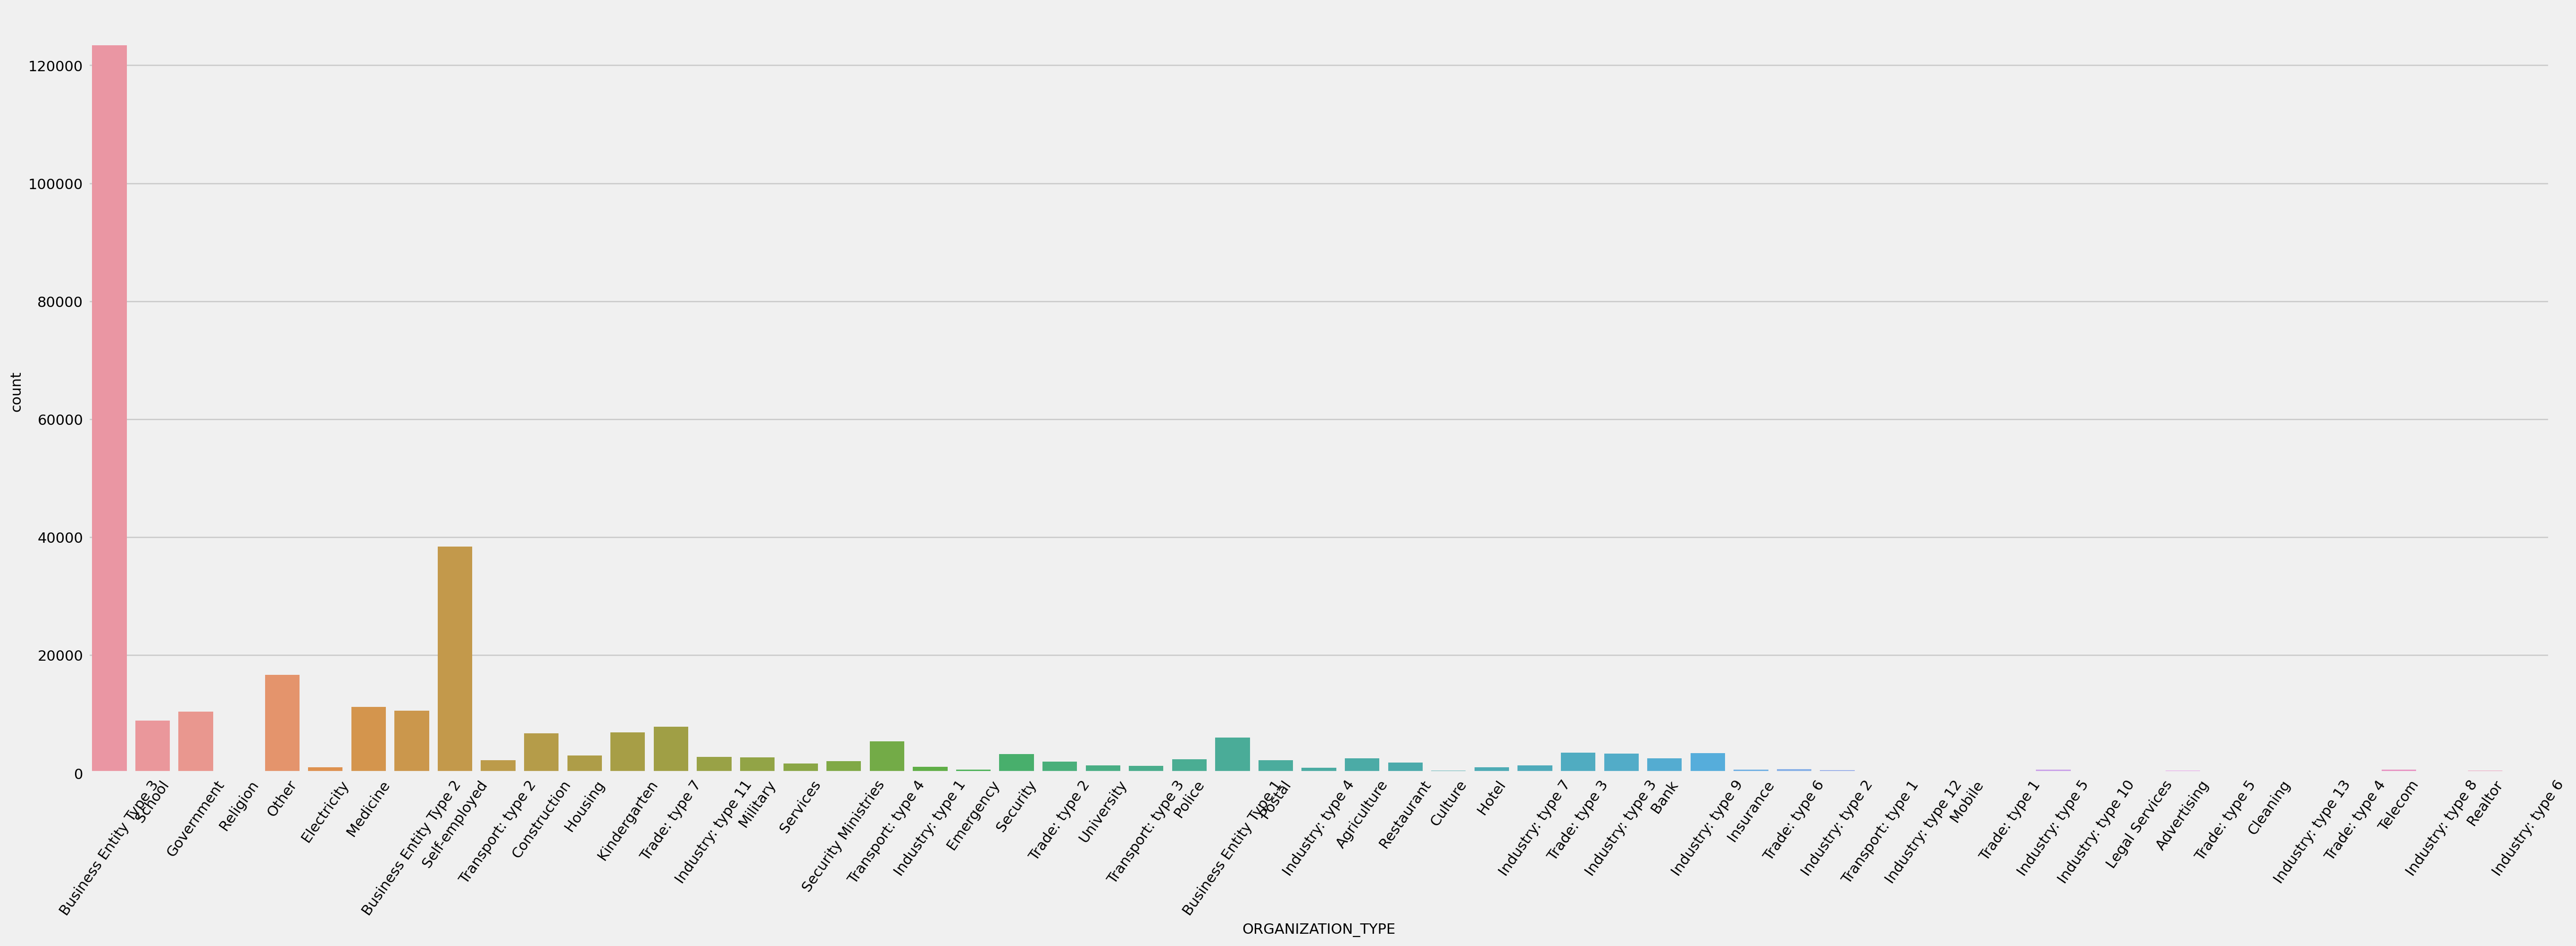

In [70]:
plt.figure(figsize=(30,10), dpi = 200)
plt.rcParams.update({'font.size': 12})
sns.countplot(data=application_train, x='ORGANIZATION_TYPE')
plt.xticks(rotation=55)
plt.show()

Le type d'organisation le plus fréquent parmi les clients est de loin les entités de busness de type 3. 

In [71]:
application_train["ORGANIZATION_TYPE"].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'Electricity', 'Medicine', 'Business Entity Type 2',
       'Self-employed', 'Transport: type 2', 'Construction', 'Housing',
       'Kindergarten', 'Trade: type 7', 'Industry: type 11', 'Military',
       'Services', 'Security Ministries', 'Transport: type 4',
       'Industry: type 1', 'Emergency', 'Security', 'Trade: type 2',
       'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'Industry

### Exploration des variables numériques:

In [72]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_OUTLIERS,PREVIOUS_LOANS_COUNT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,False,8.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.510853,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,False,4.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,19046,-225.0,-4260.0,-2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,False,2.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,19005,-3039.0,-9833.0,-2437,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,0.510853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974,False,5.561196
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,19932,-3038.0,-4311.0,-3458,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,0.510853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,False,1.000000


In [73]:
col_num = application_train.select_dtypes('float64', 'int64').columns

In [74]:
print("Nombres de variables numériques:", len(col_num))
print(col_num)

Nombres de variables numériques: 29
Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE',
       'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'PREVIOUS_LOANS_COUNT'],
      dtype='object')


<Axes: xlabel='AMT_INCOME_TOTAL', ylabel='Count'>

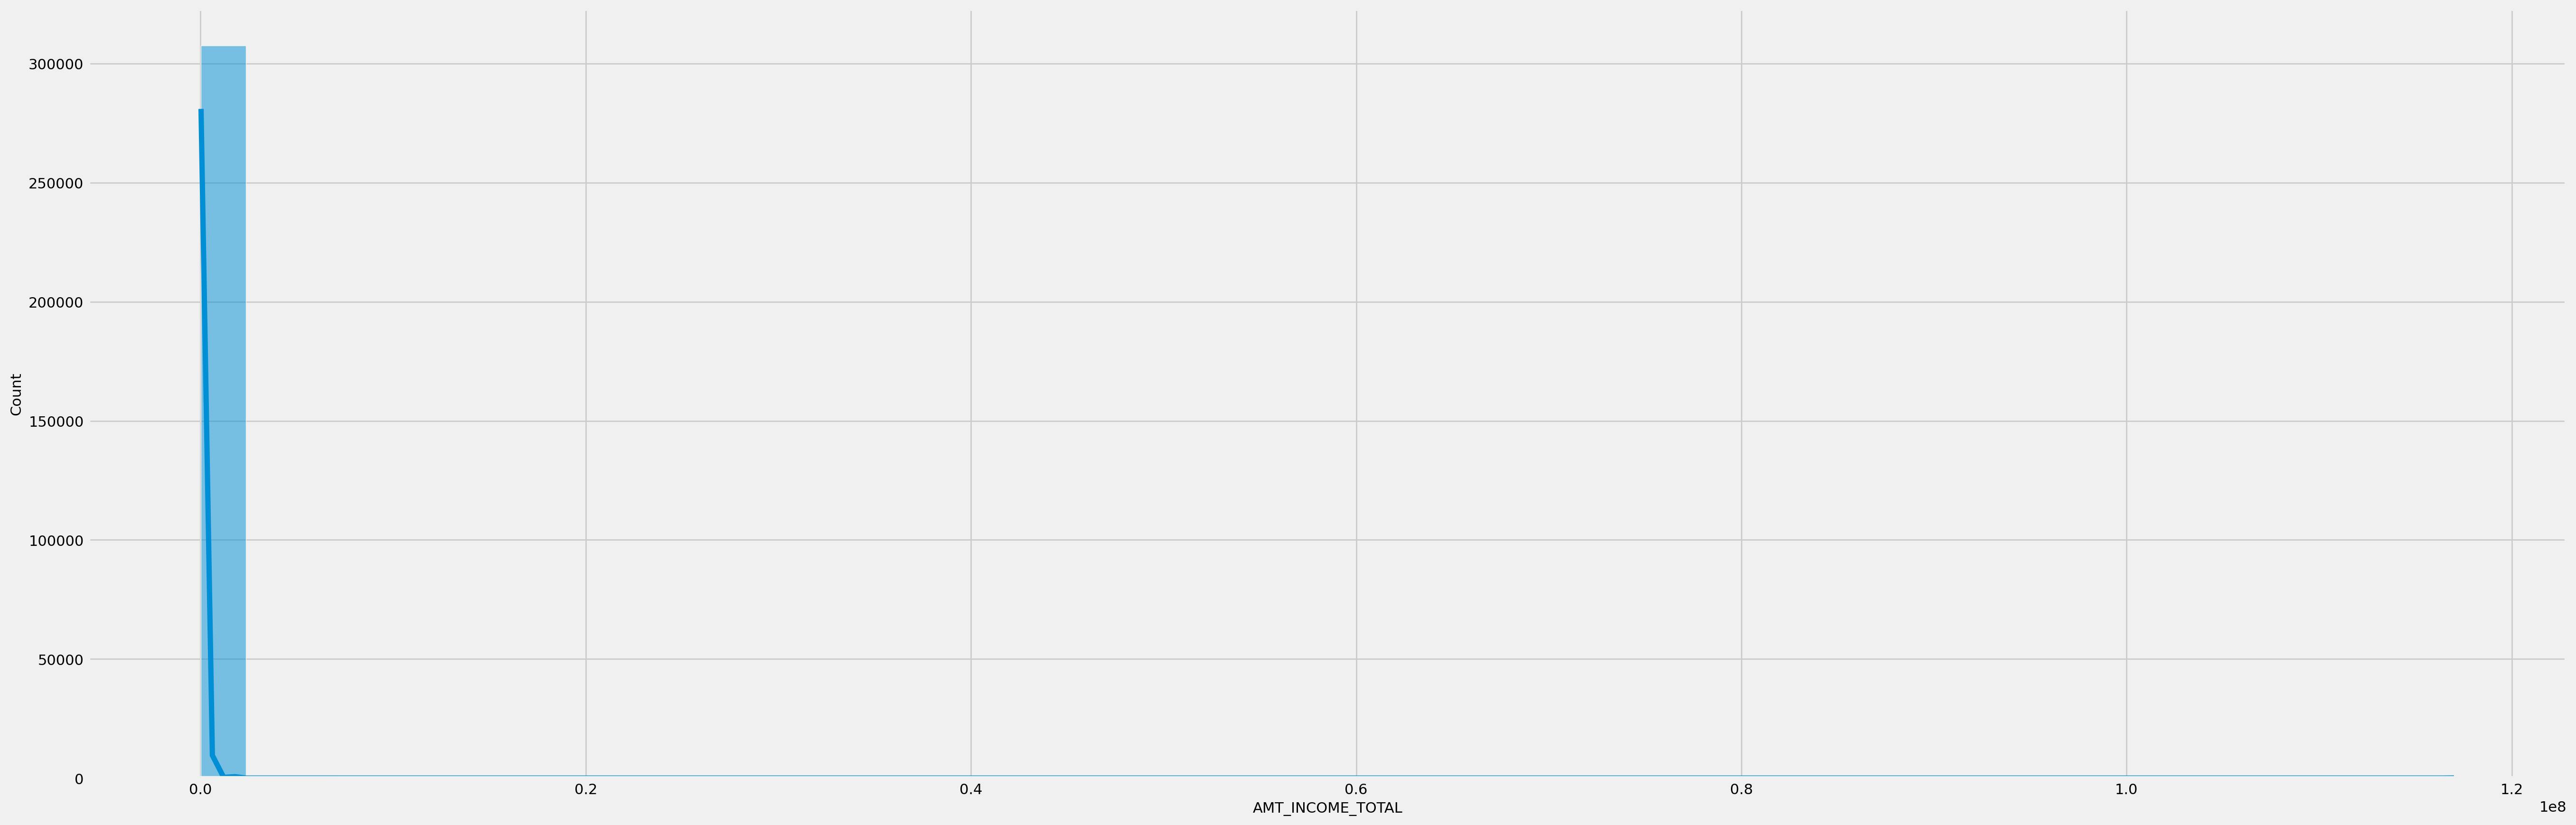

In [75]:
plt.figure(figsize=(30,10), dpi = 200)
#for col in col_num:
sns.histplot(application_train, x = 'AMT_INCOME_TOTAL', kde = True, bins = 50 )
#plt.xlim(0, 100)

In [76]:
application_train[col_num].describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREVIOUS_LOANS_COUNT
count,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,307511.000000,157504.000000,154491.000000,157504.000000,154491.000000,157504.000000,154491.000000,159080.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-2384.169325,-4986.120328,2.152665,5.143927e-01,0.510853,0.977735,0.226282,0.977065,0.222315,0.977752,0.225897,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974,5.561196
std,2.371231e+05,4.024908e+05,14493.454517,3.692794e+05,0.013831,2117.381973,3522.886321,0.910679,1.908550e-01,0.174464,0.059223,0.144641,0.064575,0.143709,0.059897,0.145067,0.107462,2.397000,0.445956,2.375849,0.361689,826.807143,0.077983,0.103009,0.190366,0.851923,0.738507,1.738528,4.052453
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-17912.000000,-24672.000000,1.000000,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-2760.000000,-7479.500000,2.000000,3.929737e-01,0.417100,0.976700,0.166700,0.976700,0.166700,0.976700,0.166700,0.041200,0.000000,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
50%,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-2219.000000,-4504.000000,2.000000,5.654672e-01,0.510853,0.981600,0.166700,0.981600,0.166700,0.981600,0.166700,0.068800,0.000000,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.899974,5.000000
75%,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-933.000000,-2010.000000,3.000000,6.634218e-01,0.636376,0.986600,0.333300,0.986600,0.333300,0.986600,0.333300,0.127600,2.000000,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.267395,0.265474,3.000000,7.000000
max,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,0.000000,0.000000,20.000000,8.549997e-01,0.896010,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,348.000000,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000,116.000000


------------------------
Pour les variables numériques (les variables catégorielles aussi) on peut les explorer sur les résultats du package suivant: 

In [77]:
# import dataprep
# from dataprep.eda import create_report
# create_report(application_train)

On peut bien voir dans la matrice de correlation qu'il y a des paires de variables qui sont fortement correleés\
comme par exemples (AMT_CREDIT/ REGION_POPULATION_RELATIVE), (CNT_CHILDREN/CNT_FAM_MEMBERS), .... .\
On pensera donc à tester le retrait d'une de ces paires de varibles et leur utilisation total lors de la modélisation.

# Extraction des features:

In [78]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Preprocess application_train/test.csv
def application_train_function(name_data, num_rows = None, nan_as_category = False):
    
    # Read data
    if name_data == 'application_train':
        df = pd.read_csv(path + 'application_train.csv', nrows= num_rows)
    else:
        df = pd.read_csv(path + 'application_test.csv', nrows= num_rows)
        
    #test_df = pd.read_csv(path + 'application_test.csv', nrows= num_rows)
    print("Train samples: {}".format(len(df)))
    #df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    #del test_df
    gc.collect()
    return df

In [79]:
feat_application_train = application_train_function('application_train', num_rows = None, nan_as_category = False)
feat_application_test = application_train_function('application_test', num_rows = None, nan_as_category = False)

# # Sauvegardons le dataframe:
# path_sauvgarde_feat_extracted ="C:/Users/aella/OneDrive/Bureau/apprentissage_data_science/Openclassrooms/projet7/feature_extracted"
 

# feat_application_train.to_csv(path_sauvgarde_feat_extracted + "/feat_application_train.csv", index = True)
# feat_application_test.to_csv(path_sauvgarde_feat_extracted + "/feat_application_test.csv", index = True)


Train samples: 307511
Train samples: 48744


In [80]:
print(feat_application_train.shape)
print(feat_application_test.shape)

(307507, 247)
(48744, 244)


In [ ]:
#### Extraction des feature pour le data set sans correlation `application_train_without_corr `:

In [ ]:

# # One-hot encoding for categorical columns with get_dummies
# def one_hot_encoder(df, nan_as_category = True):
#     original_columns = list(df.columns)
#     categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
#     df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
#     new_columns = [c for c in df.columns if c not in original_columns]
#     return df, new_columns

# # Preprocess application_train_without_corr
# def application_train_without_corr_function(num_rows = None, nan_as_category = False):
    
#     # Read data
#     #df = pd.read_csv(path + 'application_train.csv', nrows= num_rows)
#     df = application_train_without_corr
#     print("Train samples: {}".format(len(df)))
#     #df = df.append(test_df).reset_index()
#     # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
#     df = df[df['CODE_GENDER'] != 'XNA']
    
#     # Categorical features with Binary encode (0 or 1; two categories)
#     for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
#         df[bin_feature], uniques = pd.factorize(df[bin_feature])
#     # Categorical features with One-Hot encode
#     df, cat_cols = one_hot_encoder(df, nan_as_category)
    
#     # NaN values for DAYS_EMPLOYED: 365.243 -> nan
#     df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
#     # Some simple new features (percentages)
#     df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
#     df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
#     df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
#     df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
#     df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
#     #del test_df
#     gc.collect()
#     return df

# feat_application_train_without_corr = application_train_without_corr_function(num_rows = None, nan_as_category = False)


# # Sauvegardons le dataframe:
# path_sauvgarde_feat_extracted ="C:/Users/aella/OneDrive/Bureau/apprentissage_data_science/Openclassrooms/projet7/feature_extracted"
 

# feat_application_train_without_corr.to_csv(path_sauvgarde_feat_extracted + "/feat_application_train_without_corr.csv", index = True)

In [ ]:
#### Extraction des feature pour le data set `application_test_without_corr `:

In [90]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

path = "notebooks_P7/Data_projet7/new_data/"
# Preprocess application_test_without_corr.csv
def application_test_function(num_rows = None, nan_as_category = False):
    
    # Read data
    df = pd.read_csv(path + 'application_test_without_corr.csv', nrows= num_rows)
   
    print("Test samples: {}".format(len(df)))
   
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    gc.collect()
    return df

# ---------- extraction
feat_application_test_without_corr = application_test_function(num_rows = None, nan_as_category = False)

# # Sauvegardons le dataframe:
# path_sauvgarde_feat_extracted ="C:/Users/aella/OneDrive/Bureau/apprentissage_data_science/Openclassrooms/projet7/feature_extracted"
 

# feat_application_test_without_corr.to_csv(path_sauvgarde_feat_extracted + "/feat_application_test_without_corr.csv", index = True)



Test samples: 48744


----------------------------------------------

In [81]:
# Preprocess bureau.csv and bureau_balance.csv
path_1 = "notebooks_P7/Data_projet7/base_data/Projet+Mise+en+prod+-+home-credit-default-risk/"
def bureau_and_balance_function(num_rows = None, nan_as_category = True):
    
    bureau = pd.read_csv(path_1 + 'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path_1 + 'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [82]:
# bureau et bureau_balance concatené 
feat_bureau_and_balance = bureau_and_balance_function(num_rows = None, nan_as_category = True)


In [83]:

# Preprocess previous_applications.csv
def previous_applications_function(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path_1 + 'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


In [84]:
# Preprocess POS_CASH_balance.csv
def pos_cash_function(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path_1 +'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments_function(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path_1 + 'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance_function(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path_1 + 'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [85]:
feat_pos_cash = pos_cash_function(num_rows = None, nan_as_category = True)

In [86]:
feat_installments_payments = installments_payments_function(num_rows = None, nan_as_category = True)

In [87]:
feat_credit_card_balance_function = credit_card_balance_function(num_rows = None, nan_as_category = True)

In [88]:
feat_previous_application = previous_applications_function(num_rows = None, nan_as_category = True)

In [89]:
feat_credit_card_balance = credit_card_balance_function(num_rows = None, nan_as_category = True)

In [ ]:
# Sauvegardons les dataframes:
#path_sauvgarde_feat_extracted ="C:/Users/aella/OneDrive/Bureau/apprentissage_data_science/Openclassrooms/projet7/feature_extracted"
#import os  
#os.makedirs(path_sauvgarde_feat_extracted, exist_ok = True)  

# feat_bureau_and_balance.to_csv(path_sauvgarde_feat_extracted + "/feat_bureau_and_balance.csv", index = True)

# feat_credit_card_balance.to_csv(path_sauvgarde_feat_extracted + "/feat_credit_card_balance.csv", index = True)

# feat_installments_payments.to_csv(path_sauvgarde_feat_extracted + "/feat_installments_payments.csv", index = True)

# feat_pos_cash.to_csv(path_sauvgarde_feat_extracted + "/feat_pos_cash.csv", index = True)

# feat_previous_application.to_csv(path_sauvgarde_feat_extracted + "/feat_previous_application.csv", index = True)


### Regroupement des data sets avec les features extraites

Le regroupement se fait selon le schema ci-dessous:

<img src = "notebooks_P7\images\schema_de_jointure_des_data_sets.png" width = "600" height = "500">

In [91]:
feat_installments_payments.head(2)

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,17397.900,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.0,19.0,0.0,0.0,0.0,0.0,0.0,53093.745,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19


In [92]:
df_train = feat_application_train.merge(feat_bureau_and_balance, on="SK_ID_CURR"
                                 ).merge(feat_previous_application, on="SK_ID_CURR"
                                                      ).merge(feat_pos_cash, on="SK_ID_CURR"
                                 ).merge(feat_installments_payments, on="SK_ID_CURR"
                                                      ).merge(feat_credit_card_balance, on="SK_ID_CURR")

In [93]:
df_test = feat_application_test.merge(feat_bureau_and_balance, on="SK_ID_CURR"
                                 ).merge(feat_previous_application, on="SK_ID_CURR"
                                                      ).merge(feat_pos_cash, on="SK_ID_CURR"
                                 ).merge(feat_installments_payments, on="SK_ID_CURR"
                                                      ).merge(feat_credit_card_balance, on="SK_ID_CURR")

### Suppression des variables hautement correlées (corrélation >0.90):

In [94]:
df_train.shape

(72793, 797)

In [95]:
# 1. Calculons la matrice de corrélation
correlation_matrix = df_train.corr()

# 2. Identifier les paires fortement corrélées (corrélation > 0.90)
strong_correlation_threshold = 0.90
strong_correlations = {}
for col in correlation_matrix.columns:
    correlated_features = correlation_matrix.index[correlation_matrix[col].abs() > strong_correlation_threshold].tolist()
    if len(correlated_features) > 1:
        strong_correlations[col] = correlated_features

In [96]:
strong_correlations

{'AMT_CREDIT': ['AMT_CREDIT', 'AMT_GOODS_PRICE'],
 'AMT_GOODS_PRICE': ['AMT_CREDIT', 'AMT_GOODS_PRICE'],
 'DAYS_EMPLOYED': ['DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC'],
 'FLAG_EMP_PHONE': ['FLAG_EMP_PHONE',
  'NAME_INCOME_TYPE_Pensioner',
  'ORGANIZATION_TYPE_XNA'],
 'REGION_RATING_CLIENT': ['REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY'],
 'REGION_RATING_CLIENT_W_CITY': ['REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY'],
 'APARTMENTS_AVG': ['APARTMENTS_AVG',
  'LIVINGAPARTMENTS_AVG',
  'LIVINGAREA_AVG',
  'APARTMENTS_MODE',
  'LIVINGAPARTMENTS_MODE',
  'APARTMENTS_MEDI',
  'LIVINGAPARTMENTS_MEDI',
  'LIVINGAREA_MEDI'],
 'BASEMENTAREA_AVG': ['BASEMENTAREA_AVG',
  'BASEMENTAREA_MODE',
  'BASEMENTAREA_MEDI'],
 'YEARS_BEGINEXPLUATATION_AVG': ['YEARS_BEGINEXPLUATATION_AVG',
  'YEARS_BEGINEXPLUATATION_MODE',
  'YEARS_BEGINEXPLUATATION_MEDI'],
 'YEARS_BUILD_AVG': ['YEARS_BUILD_AVG',
  'YEARS_BUILD_MODE',
  'YEARS_BUILD_MEDI'],
 'COMMONAREA_AVG': ['COMMONAREA_AVG', 'COMMONAREA_MODE

In [97]:
# Créer un dictionnaire pour stocker les paires corrélées pour chaque feature
correlated_features_dict = {}

# Remplir le dictionnaire des paires corrélées
for feature, correlated_features in strong_correlations.items():
    for correlated_feature in correlated_features:
        if correlated_feature in correlated_features_dict:
            correlated_features_dict[correlated_feature].append(feature)
        else:
            correlated_features_dict[correlated_feature] = [feature]

# Créer un dictionnaire pour stocker le nombre de valeurs manquantes pour chaque feature
nan_counts_dict = {feature: df_train[feature].isnull().sum() for feature in df_train.columns}


In [98]:
# Créer une liste de features à supprimer
features_to_remove = []

# Pour chaque colonne du dataframe, vérifier si elle est présente dans les paires corrélées
# et comparer le nombre de valeurs manquantes dans chaque feature de la paire
for feature in df_train.columns:
    if feature in correlated_features_dict:
        correlated_features = correlated_features_dict[feature]
        nan_counts = [nan_counts_dict[feat] for feat in correlated_features]
        feature_with_most_nans = correlated_features[nan_counts.index(max(nan_counts))]
        
        # Ajouter le feature à supprimer dans la liste, s'il n'a pas déjà été ajouté
        if feature_with_most_nans not in features_to_remove:
            features_to_remove.append(feature_with_most_nans)

In [99]:
len(features_to_remove)

117

In [100]:
# Supprimer les features de la liste
df_train_without_corr = df_train.drop(columns=features_to_remove, axis = 1)

#Appliquons cela au data sets de test
df_test_without_corr = df_test.drop(columns=features_to_remove, axis = 1)

In [101]:
print(df_train.shape)
print(df_train_without_corr.shape)
print(df_test_without_corr.shape)

(72793, 797)
(72793, 680)
(14464, 677)


In [102]:
print("Dimension:", df_train_without_corr.shape)
print("Valeurs dupliquées:", df_train.shape[0] - df_train.duplicated().value_counts()[0])

Dimension: (72793, 680)
Valeurs dupliquées: 0


In [103]:
df_train.isna().mean()

SK_ID_CURR                                                               0.000000
TARGET                                                                   0.000000
CODE_GENDER                                                              0.000000
FLAG_OWN_CAR                                                             0.000000
FLAG_OWN_REALTY                                                          0.000000
CNT_CHILDREN                                                             0.000000
AMT_INCOME_TOTAL                                                         0.000000
AMT_CREDIT                                                               0.000000
AMT_ANNUITY                                                              0.000096
AMT_GOODS_PRICE                                                          0.000082
REGION_POPULATION_RELATIVE                                               0.000000
DAYS_BIRTH                                                               0.000000
DAYS_EMPLOYED   

In [104]:
df_train_without_corr.isna().mean()

SK_ID_CURR                                                               0.000000
TARGET                                                                   0.000000
CODE_GENDER                                                              0.000000
FLAG_OWN_CAR                                                             0.000000
FLAG_OWN_REALTY                                                          0.000000
CNT_CHILDREN                                                             0.000000
AMT_INCOME_TOTAL                                                         0.000000
AMT_CREDIT                                                               0.000000
AMT_ANNUITY                                                              0.000096
REGION_POPULATION_RELATIVE                                               0.000000
DAYS_BIRTH                                                               0.000000
DAYS_REGISTRATION                                                        0.000000
DAYS_ID_PUBLISH 

Les colonnes `CC_NAME_CONTRACT_STATUS_nan_...` signifie que le statut etait inconnu ou non renseigné ce qui signifie que\
les infos données par ces colonnes seront eronnées. On va donc supprimer ces colonnes:

In [105]:
cols_infos_inconnu = ['CC_NAME_CONTRACT_STATUS_nan_MIN', 'CC_NAME_CONTRACT_STATUS_nan_MAX',
                      'CC_NAME_CONTRACT_STATUS_nan_MEAN', 'CC_NAME_CONTRACT_STATUS_nan_SUM', 
                      'CC_NAME_CONTRACT_STATUS_nan_VAR']
df_train_without_corr.drop(cols_infos_inconnu, axis =1, inplace = True)

df_test_without_corr.drop(cols_infos_inconnu, axis =1, inplace = True)

In [106]:
df_test_without_corr.shape

(14464, 672)

In [107]:
df_train_without_corr.shape

(72793, 675)

In [108]:
df_train_without_corr.dropna(axis = 1, inplace = True)
df_test_without_corr.dropna(axis = 1, inplace = True)

In [109]:
df_train_without_corr.isna().mean().sort_values(ascending = False)

SK_ID_CURR                                                               0.0
PREV_NAME_PRODUCT_TYPE_XNA_MEAN                                          0.0
PREV_NAME_PORTFOLIO_XNA_MEAN                                             0.0
PREV_NAME_PORTFOLIO_POS_MEAN                                             0.0
PREV_NAME_PORTFOLIO_Cash_MEAN                                            0.0
PREV_NAME_PORTFOLIO_Cards_MEAN                                           0.0
PREV_NAME_GOODS_CATEGORY_nan_MEAN                                        0.0
PREV_NAME_GOODS_CATEGORY_XNA_MEAN                                        0.0
PREV_NAME_GOODS_CATEGORY_Weapon_MEAN                                     0.0
PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN                                   0.0
PREV_NAME_GOODS_CATEGORY_Tourism_MEAN                                    0.0
PREV_NAME_GOODS_CATEGORY_Sport and Leisure_MEAN                          0.0
PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment_MEAN                   0.0

In [110]:
df_test_without_corr.isna().mean().sort_values(ascending = False)

SK_ID_CURR                                                               0.0
PREV_NAME_GOODS_CATEGORY_Tourism_MEAN                                    0.0
PREV_NAME_PRODUCT_TYPE_nan_MEAN                                          0.0
PREV_NAME_PRODUCT_TYPE_x-sell_MEAN                                       0.0
PREV_NAME_PRODUCT_TYPE_walk-in_MEAN                                      0.0
PREV_NAME_PRODUCT_TYPE_XNA_MEAN                                          0.0
PREV_NAME_PORTFOLIO_nan_MEAN                                             0.0
PREV_NAME_PORTFOLIO_XNA_MEAN                                             0.0
PREV_NAME_PORTFOLIO_POS_MEAN                                             0.0
PREV_NAME_PORTFOLIO_Cash_MEAN                                            0.0
PREV_NAME_PORTFOLIO_Cards_MEAN                                           0.0
PREV_NAME_GOODS_CATEGORY_nan_MEAN                                        0.0
PREV_NAME_GOODS_CATEGORY_XNA_MEAN                                        0.0

In [113]:
print(df_train_without_corr.shape)
print(df_test_without_corr.shape)

(72793, 492)
(14464, 496)


On constate que les deux datas sets n'ont pas le même nobre de colonne.
On veut garder les mêmes colonnes sur les deux data sets:

In [114]:
col_commun = df_train_without_corr.drop("TARGET", axis = 1).columns

In [ ]:
# df_train_without_corr.drop(['NAME_INCOME_TYPE_Maternity leave', 'NAME_FAMILY_STATUS_Unknown'], axis = 1, inplace = True)
# col_commun = df_train_without_corr.drop("TARGET", axis = 1).columns

In [116]:
# df_test_without_corr = df_test_without_corr[col_commun]

In [ ]:
# print(df_train_without_corr.shape)
# print(df_test_without_corr.shape)

Sans la Target on a bien les mêmes colones dans les deux data sets. On peut alors les sauvegarder.

## Features engineering
Il peut être pertinent d'enrichir l'échantillon par un ajout de variables spécifiques à la problématique métier. N'étant pas spécialisé dans l'expertise des crédits, on pourra mener les modélisations avec une étape de features selection qui déterminera la pertinence de ces variables, ainsi que toutes les autres variables de l'échantillon.

### 3 features extraites des précédentes étapes
Pour rappel, les étapes précédentes consistaient uniquement à établir des liens entre nos fichiers, des fusions de table dans le but d'enrichir l'échantillon de travail. Ceci étant, avant de procéder au merging des éléments, on a pu facilement extraire __3 variables de moyenne et de comptage__.

``PREVIOUS_LOANS_COUNT`` from bureau.csv: Nombre total des précédents crédits pris par chaque client\
``MONTHS_BALANCE_MEAN`` from bureau_balance.csv: Solde moyen mensuel des précédents crédits\
``PREVIOUS_APPLICATION_COUNT`` from previous_application.csv: Nombre de demandes antérieures des clients au crédit immobilier


### Création de 4 nouvelles variables métiers
Sans être expert en crédit bancaire, on peut assez facilement apporter quelques ratios explicatifs. D'autant plus qu'une veille parallèle permet de mieux comprendre les enjeux attendus. Voyons ci-dessous quelles features est-il pertinent d'intégrer.

``CREDIT_INCOME_PERCENT``: Pourcentage du montant du crédit par rapport au revenu d'un client\
``ANNUITY_INCOME_PERCENT``: Pourcentage de la rente de prêt par rapport au revenu d'un client\
``CREDIT_TERM``: Durée du paiement en mois\
``DAYS_EMPLOYED_PERCENT``: Pourcentage des jours employés par rapport à l'âge du client

In [117]:
#Before…
print("train set:", df_train_without_corr.shape)
#print("test set:", df_test_without_corr.shape)

train set: (72793, 492)


In [ ]:
#test set
# df_test_without_corr['CREDIT_INCOME_PERCENT'] = df_test['AMT_CREDIT'] / df_test['AMT_INCOME_TOTAL']
# df_test_without_corr['ANNUITY_INCOME_PERCENT'] = df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']
# df_test_without_corr['CREDIT_TERM'] = df_test['AMT_ANNUITY'] / df_test['AMT_CREDIT']
# df_test_without_corr['DAYS_EMPLOYED_PERCENT'] = df_test['DAYS_EMPLOYED'] / df_test['DAYS_BIRTH']

In [118]:
# train set
df_train_without_corr['CREDIT_INCOME_PERCENT'] = df_train['AMT_CREDIT'] / df_train['AMT_INCOME_TOTAL']
df_train_without_corr['ANNUITY_INCOME_PERCENT'] = df_train['AMT_ANNUITY'] / df_train['AMT_INCOME_TOTAL']
df_train_without_corr['CREDIT_TERM'] = df_train['AMT_ANNUITY'] / df_train['AMT_CREDIT']
df_train_without_corr['DAYS_EMPLOYED_PERCENT'] = df_train['DAYS_EMPLOYED'] / df_train['DAYS_BIRTH']

In [119]:
#After…
print("train set:", df_train_without_corr.shape)
#print("test set:", df_test_without_corr.shape)

train set: (72793, 496)


In [ ]:
# #New Variables from features engineering
features_engin = ['PREVIOUS_LOANS_COUNT', 'MONTHS_BALANCE_MEAN', 'PREVIOUS_APPLICATION_COUNT',
                    'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']

Supprimons les lignes identifiées comme outliers pour la colonne "DAYS_EMPLOYED":

In [121]:
#df_train_without_corr.drop(df_train_without_corr.loc[df_train_without_corr['DAYS_EMPLOYED_OUTLIERS']=='True'].index, inplace=True)


In [ ]:
# df_train_without_corr.drop("DAYS_EMPLOYED_OUTLIERS",axis = 1, inplace = True)
# df_test_without_corr.drop("DAYS_EMPLOYED_OUTLIERS", axis = 1, inplace = True)

In [122]:
df_train_without_corr.isna().mean().sort_values(ascending = False)

DAYS_EMPLOYED_PERCENT                                                    0.145797
CREDIT_TERM                                                              0.000096
ANNUITY_INCOME_PERCENT                                                   0.000096
PREV_NAME_GOODS_CATEGORY_nan_MEAN                                        0.000000
PREV_NAME_GOODS_CATEGORY_Sport and Leisure_MEAN                          0.000000
PREV_NAME_GOODS_CATEGORY_Tourism_MEAN                                    0.000000
PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN                                   0.000000
PREV_NAME_GOODS_CATEGORY_Weapon_MEAN                                     0.000000
PREV_NAME_GOODS_CATEGORY_XNA_MEAN                                        0.000000
PREV_NAME_PORTFOLIO_Cash_MEAN                                            0.000000
PREV_NAME_PORTFOLIO_Cards_MEAN                                           0.000000
PREV_NAME_GOODS_CATEGORY_Other_MEAN                                      0.000000
PREV_NAME_PORTFO

In [123]:
mean_values = df_train_without_corr.mean()
df_train_without_corr.fillna(mean_values, inplace=True)

In [ ]:
# mean_values = df_test.mean()
# df_test_without_corr.fillna(mean_values, inplace=True)

In [124]:
#After…
print("train set:", df_train_without_corr.shape)

train set: (72793, 496)


#### Sauvegarde du data set:

In [125]:
#df_train.to_csv(path_sauvgarde_feat_extracted + "/df_train.csv", index = False)    #non necessaire
df_train_without_corr.to_csv("notebooks_P7/Data_projet7/new_data/df_train_without_corr.csv", index = False)

In [ ]:
#common_columns = df_train_without_corr.columns.intersection(df_test_without_corr.columns)

In [ ]:
#common_columns

####-------------------------------------------------------------------------------------Fin EDA----------------------------------------

In [127]:
#df_train_without_corr[["CREDIT_INCOME_PERCENT", "ANNUITY_INCOME_PERCENT", "DAYS_EMPLOYED_PERCENT", "PREVIOUS_LOANS_COUNT"]]

## Préparation du data set pour le tableau de bord:
Pour avoir les infos avnt toute transformation surtout concerant les variables catégorielles

In [ ]:
bureau_bureau_balance = bureau.merge(bureau_balance, on = "SK_ID_BUREAU")

In [ ]:
installments_payments.dropna(axis=1, inplace = True)
credit_card_balance.dropna(axis=1, inplace = True)
POS_CASH_balance.dropna(axis=1, inplace = True)
previous_application.dropna(axis=1, inplace = True)
application_train.dropna(axis=1, inplace = True)
application_test.dropna(axis=1, inplace = True)

In [ ]:
installments_payments.dropna(axis=0, inplace = True)
credit_card_balance.dropna(axis=0, inplace = True)
POS_CASH_balance.dropna(axis=0, inplace = True)
previous_application.dropna(axis=0, inplace = True)
application_train.dropna(axis=0, inplace = True)
application_test.dropna(axis=0, inplace = True)

In [ ]:
# #Cela demande beacoup d'espace memoire

# df_infos_clients =application_test.merge(previous_application.merge(POS_CASH_balance.merge(installments_payments.merge(credit_card_balance, 
#                                                                                                                                 on="SK_ID_PREV"), 
#                                                                        on = "SK_ID_PREV"
#                                                                       ), 
#                                                                           on = "SK_ID_PREV") , 
#                                                                        on="SK_ID_CURR")